# Fusión Multimodal: DINOv3 + F2LLM + MLP Sensorial

Este cuaderno combina embeddings de tres modelos congelados:
- **DINOv3 ViT-L/16**
- **F2LLM**
- **MLP Sensorial**

## 1. Importar librerías

In [1]:
import json
import os
import copy
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from PIL import Image

from transformers import (
    AutoImageProcessor,
    AutoModel,
    AutoTokenizer,
)
from peft import PeftModel

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_recall_curve,
)

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory

print(f"PyTorch: {torch.__version__}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

PyTorch: 2.10.0+cu128
Device: cuda


## 2. Configuración

In [ ]:
os.environ["HF_TOKEN"] = ""

MAIN_PATH       = ".."
GROUP_ID        = "BeingChillingWeWillWin"
MODEL_ID        = "multimodalFusionMacro"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_split.json")
DATA_VAL_PATH   = os.path.join(MAIN_PATH, "preprocessed_data", "dev_split.json")
DATA_TEST_PATH  = os.path.join(MAIN_PATH, "preprocessed_data", "test_split.json")
DATA_BASE_DIR   = os.path.join(MAIN_PATH, "materials", "dataset_task2_exist2026")

PREDICTIONS_DIR = os.path.join(MAIN_PATH, "predictions")
WEIGHTS_DIR     = os.path.join(MAIN_PATH, "weights")
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR,     exist_ok=True)

DINO_WEIGHTS_PATH      = os.path.join(MAIN_PATH, "weights", "DINOv3-ViTL16_img_final")
F2LLM_WEIGHTS_PATH     = os.path.join(MAIN_PATH, "weights", "F2LLM-4B_combined_text_final")
SENSORIAL_WEIGHTS_PATH = os.path.join(MAIN_PATH, "weights", "BeingChillingWeWillWin_MLPsensorial_model.pt")

DINO_MODEL_NAME  = "facebook/dinov3-vitl16-pretrain-lvd1689m"
F2LLM_MODEL_NAME = "codefuse-ai/F2LLM-4B"

# ── Columnas ─────────────────────────────────────────────────────────────────
LABEL_COLUMN = "label"
FEATURE_COLS = [
    'ET_reaction_time', 'ET_fixations_count', 'ET_fixations_duration_mean_ns',
    'ET_fixations_duration_std_ns', 'ET_saccades_count', 'ET_saccades_duration_mean_ns',
    'ET_blinks_count', 'ET_blinks_duration_min_ns', 'ET_blinks_duration_mean_ns',
    'HR_garmin_hr_std', 'HR_garmin_hr_mean', 'HR_garmin_hr_max', 'HR_garmin_hr_min'
]
INPUT_DIM_SENSORIAL = len(FEATURE_COLS)  # 13

# ── Dimensiones de los embeddings de cada backbone ───────────────────────────
DINO_EMBED_DIM      = 1024
F2LLM_EMBED_DIM     = 2056
SENSORIAL_EMBED_DIM = 32

# ── Hiperparámetros de entrenamiento ─────────────────────────────────────────
BATCH_SIZE     = 32
MAX_EPOCHS     = 100
PATIENCE       = 5
LR             = 3e-4
WEIGHT_DECAY   = 1e-2
MAX_SEQ_LEN    = 256

label_map         = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

## 3. Carga de datos

In [3]:
def load_json_dataset(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data.values())

def build_combined_text(row):
    img_desc = str(row.get('image_description', '') or '')
    txt      = str(row.get('text', '') or '')
    return f"descripcion imagen: {img_desc}. Texto: {txt}"

def expand_sensorial(df):
    """Expande el dict 'sensorial_features_normalized' a columnas planas."""
    if 'sensorial_features_normalized' in df.columns:
        sensorial_expanded = df['sensorial_features_normalized'].apply(
            lambda x: x if isinstance(x, dict) else {}
        ).apply(pd.Series)
        for col in FEATURE_COLS:
            if col not in df.columns:
                df[col] = sensorial_expanded.get(col, 0.0)
    return df

train_df = load_json_dataset(DATA_TRAIN_PATH)
val_df   = load_json_dataset(DATA_VAL_PATH)
test_df  = load_json_dataset(DATA_TEST_PATH)

for df in [train_df, val_df, test_df]:
    df['combined_text'] = df.apply(build_combined_text, axis=1)
    expand_sensorial(df)

train_df['label_int'] = train_df[LABEL_COLUMN].map(label_map)
val_df['label_int']   = val_df[LABEL_COLUMN].map(label_map)
test_df['label_int']  = -1

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"\nDistribución TRAIN:\n{train_df[LABEL_COLUMN].value_counts()}")
print(f"\nDistribución VAL:\n{val_df[LABEL_COLUMN].value_counts()}")

Train: 2146 | Val: 537 | Test: 687

Distribución TRAIN:
label
YES    1282
NO      864
Name: count, dtype: int64

Distribución VAL:
label
YES    321
NO     216
Name: count, dtype: int64


## 4. Carga y congelado de los backbones

### 4.1 DINOv3 backbone (congelado)

In [4]:
class DINOv3Embedder(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        return outputs.pooler_output
    
    @classmethod
    def from_checkpoint(
        cls,
        checkpoint_path: str,
        base_model_name: str,
        device: str = "cpu",
    ):
        backbone = AutoModel.from_pretrained(base_model_name)
        backbone = PeftModel.from_pretrained(backbone, checkpoint_path)

        model = cls(backbone)
        
        for p in model.parameters():
            p.requires_grad = False
        
        model.eval()

        model.to(device).to(torch.bfloat16)
        
        return model

dino_full = DINOv3Embedder.from_checkpoint(
    checkpoint_path=DINO_WEIGHTS_PATH,
    base_model_name=DINO_MODEL_NAME,
    device=DEVICE,
)


Loading weights:   0%|          | 0/415 [00:00<?, ?it/s]

### 4.2 F2LLM backbone (congelado)

In [5]:
llm_tokenizer = AutoTokenizer.from_pretrained(F2LLM_MODEL_NAME)
if llm_tokenizer.pad_token is None:
    llm_tokenizer.pad_token = llm_tokenizer.eos_token

llm_base = AutoModel.from_pretrained(F2LLM_MODEL_NAME)

if llm_base.config.pad_token_id is None:
    llm_base.config.pad_token_id = llm_tokenizer.pad_token_id

llm_base = PeftModel.from_pretrained(llm_base, F2LLM_WEIGHTS_PATH)

for p in llm_base.parameters():
    p.requires_grad = False
llm_base.eval().to(DEVICE)


class F2LLMEmbedder(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = model

    def forward(self, input_ids, attention_mask):
        out = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
        )
        hidden = out.last_hidden_state  # (B, L, D)
        seq_len = attention_mask.sum(dim=1) - 1
        idx = seq_len.clamp(min=0).unsqueeze(-1).unsqueeze(-1).expand(-1, 1, hidden.size(-1))
        pooled = hidden.gather(1, idx).squeeze(1)
        return pooled


f2llm_embedder = F2LLMEmbedder(llm_base)
for p in f2llm_embedder.parameters():
    p.requires_grad = False
f2llm_embedder.eval().to(DEVICE).to(torch.bfloat16)

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

/home/alumno.upv.es/psegmar1/.conda/envs/ALC-LAB1/lib/python3.12/site-packages/peft/peft_model.py:598: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.layers.2.self_attn.q_proj.lora_A.default.weight', 'base_model.model.layers.2.self_attn.q_proj.lora_B.default.weight', 'base_model.model.layers.2.self_attn.v_proj.lora_A.default.weight', 'base_model.model.layers.2.self_attn.v_proj.lora_B.default.weight', 'base_mode

F2LLMEmbedder(
  (backbone): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 2560)
        (layers): ModuleList(
          (0-35): 36 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj)

### 4.3 MLP Sensorial (congelado)

In [6]:
class MLP(nn.Module):
    """Misma arquitectura del cuaderno de entrenamiento sensorial."""
    def __init__(self, input_dim, hidden_dims, dropout=0.3, use_bn=True):
        super().__init__()
        layers, prev = [], input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h)]
            if use_bn:
                layers += [nn.BatchNorm1d(h)]
            layers += [nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)


class SensorialEmbedder(nn.Module):
    """
    Extrae el embedding de la penúltima capa del MLP (antes de la capa de salida).
    Para hidden_dims=[128,64,32] el embedding tiene dim=32.
    """
    def __init__(self, mlp: MLP):
        super().__init__()
        self.encoder = nn.Sequential(*list(mlp.net.children())[:-1])

    def forward(self, x):
        return self.encoder(x)


mlp_sensorial = MLP(INPUT_DIM_SENSORIAL, [128, 64, 32], dropout=0.3)
mlp_state = torch.load(
    SENSORIAL_WEIGHTS_PATH,
    map_location="cpu",
    weights_only=False
)

mlp_sensorial.load_state_dict(mlp_state["model_state_dict"])

sensorial_embedder = SensorialEmbedder(mlp_sensorial)
for p in sensorial_embedder.parameters():
    p.requires_grad = False
sensorial_embedder.eval().to(DEVICE)

SensorialEmbedder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
)

## 5. Dataset multimodal

In [7]:
class MultimodalDataset(Dataset):
    """
    Devuelve para cada muestra:
      - pixel_values   : tensor imagen procesada por DINOv3
      - input_ids      : tensor de tokens del texto combinado
      - attention_mask : máscara de atención
      - sensorial      : tensor de características sensoriales normalizadas
      - labels         : 0/1 (float) o -1 para test
      - id_EXIST       : str
    """
    def __init__(self, df, base_dir, dino_processor, tokenizer,
                 feature_cols, max_len=256, is_test=False):
        self.df            = df.reset_index(drop=True)
        self.base_dir      = Path(base_dir)
        self.dino_proc     = dino_processor
        self.tokenizer     = tokenizer
        self.feature_cols  = feature_cols
        self.max_len       = max_len
        self.is_test       = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ── Imagen ────────────────────────────────────────────────────────────
        img_path = self.base_dir / row['path_memes']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color=0)
        pixel_values = self.dino_proc(images=image, return_tensors='pt')['pixel_values'].squeeze(0)

        # ── Texto ─────────────────────────────────────────────────────────────
        enc = self.tokenizer(
            row['combined_text'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        input_ids      = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)

        # ── Sensorial ─────────────────────────────────────────────────────────
        sens_vals = [float(row.get(c, 0.0) or 0.0) for c in self.feature_cols]
        sensorial = torch.tensor(sens_vals, dtype=torch.float32)

        sample = {
            'pixel_values'  : pixel_values,
            'input_ids'     : input_ids,
            'attention_mask': attention_mask,
            'sensorial'     : sensorial,
            'id_EXIST'      : str(row['id_EXIST']),
        }
        if not self.is_test:
            sample['labels'] = torch.tensor(row['label_int'], dtype=torch.float32)
        return sample


def make_loaders(train_df, val_df, test_df, dino_processor, tokenizer):
    kw = dict(
        base_dir=DATA_BASE_DIR,
        dino_processor=dino_processor,
        tokenizer=tokenizer,
        feature_cols=FEATURE_COLS,
        max_len=MAX_SEQ_LEN,
    )
    train_ds = MultimodalDataset(train_df, is_test=False, **kw)
    val_ds   = MultimodalDataset(val_df,   is_test=False, **kw)
    test_ds  = MultimodalDataset(test_df,  is_test=True,  **kw)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

dino_processor = AutoImageProcessor.from_pretrained(DINO_MODEL_NAME)

train_loader, val_loader, test_loader = make_loaders(
    train_df, val_df, test_df, dino_processor, llm_tokenizer
)
print(f"Batches — Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

Batches — Train: 68 | Val: 17 | Test: 22


## 6. Pre-cómputo de embeddings (caché en memoria)

Dado que los backbones están congelados, es más eficiente computar los embeddings
una sola vez y almacenarlos en RAM, de modo que el bucle de entrenamiento de la
cabeza de fusión sea mucho más rápido.

In [8]:
@torch.no_grad()
def extract_embeddings(loader, dino_model, text_model, sens_model, is_test=False):
    """
    Recorre el DataLoader y extrae los embeddings de los tres backbones.
    Devuelve tensores en CPU listos para ser usados en un EmbeddingDataset.
    """
    all_dino, all_text, all_sens, all_labels, all_ids = [], [], [], [], []

    for batch in loader:
        pv   = batch['pixel_values'].to(DEVICE, dtype=torch.bfloat16)
        iids = batch['input_ids'].to(DEVICE)
        amsk = batch['attention_mask'].to(DEVICE)
        sens = batch['sensorial'].to(DEVICE)

        dino_emb = dino_model(pv)                           # (B, 1024)
        text_emb = text_model(iids, amsk)                   # (B, D_llm)
        sens_emb = sens_model(sens)                         # (B, 32)

        all_dino.append(dino_emb.cpu())
        all_text.append(text_emb.cpu())
        all_sens.append(sens_emb.cpu())
        all_ids.extend(batch['id_EXIST'])

        if not is_test:
            all_labels.append(batch['labels'])

    dino_t = torch.cat(all_dino)
    text_t = torch.cat(all_text)
    sens_t = torch.cat(all_sens)
    labs_t = torch.cat(all_labels) if all_labels else None
    return dino_t, text_t, sens_t, labs_t, all_ids


print("Extrayendo embeddings de TRAIN...")
train_emb = extract_embeddings(train_loader, dino_full, f2llm_embedder, sensorial_embedder, is_test=False)
print("Extrayendo embeddings de VAL...")
val_emb   = extract_embeddings(val_loader,   dino_full, f2llm_embedder, sensorial_embedder, is_test=False)
print("Extrayendo embeddings de TEST...")
test_emb  = extract_embeddings(test_loader,  dino_full, f2llm_embedder, sensorial_embedder, is_test=True)

print(f"\nFormas TRAIN — DINO: {train_emb[0].shape} | Text: {train_emb[1].shape} | Sens: {train_emb[2].shape}")

# Inferimos la dim real del LLM desde los datos extraídos
F2LLM_EMBED_DIM = train_emb[1].shape[-1]
print(f"Dim real F2LLM: {F2LLM_EMBED_DIM}")

Extrayendo embeddings de TRAIN...


Extrayendo embeddings de VAL...


Extrayendo embeddings de TEST...



Formas TRAIN — DINO: torch.Size([2146, 1024]) | Text: torch.Size([2146, 2560]) | Sens: torch.Size([2146, 32])
Dim real F2LLM: 2560


In [9]:
class EmbeddingDataset(Dataset):
    """Dataset sencillo sobre embeddings precalculados."""
    def __init__(self, dino, text, sens, labels=None):
        self.dino   = dino
        self.text   = text
        self.sens   = sens
        self.labels = labels

    def __len__(self):
        return len(self.dino)

    def __getitem__(self, idx):
        sample = {
            'dino': self.dino[idx],
            'text': self.text[idx],
            'sens': self.sens[idx],
        }
        if self.labels is not None:
            sample['labels'] = self.labels[idx]
        return sample


def emb_loader(emb_tuple, shuffle=False):
    ds = EmbeddingDataset(*emb_tuple[:4])  # dino, text, sens, labels
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=0)

train_emb = (train_emb[0].float(), train_emb[1].float(), train_emb[2].float(), train_emb[3], train_emb[4])
val_emb   = (val_emb[0].float(),   val_emb[1].float(),   val_emb[2].float(),   val_emb[3],   val_emb[4])
test_emb  = (test_emb[0].float(),  test_emb[1].float(),  test_emb[2].float(),  test_emb[3],  test_emb[4])

train_emb_loader = emb_loader(train_emb, shuffle=True)
val_emb_loader   = emb_loader(val_emb,   shuffle=False)
test_emb_loader  = emb_loader(test_emb,  shuffle=False)

## 7. Cabezas de fusión

Se definen varias arquitecturas de cabeza de fusión. Los backbones están congelados;
solo se entrenan los parámetros de la cabeza.

In [10]:
# ── Bloque auxiliar: proyección opcional ─────────────────────────────────────
def make_proj(in_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.LayerNorm(out_dim),
        nn.GELU(),
    )


# ── Arquitectura A: Concatenación simple + MLP ────────────────────────────────
class FusionCat(nn.Module):
    """
    Concatena los tres embeddings y pasa por un MLP binario.
    total_dim = DINO_DIM + LLM_DIM + SENS_DIM
    """
    def __init__(self, dino_dim, text_dim, sens_dim, hidden_dims, dropout=0.3):
        super().__init__()
        in_dim = dino_dim + text_dim + sens_dim
        layers, prev = [], in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.GELU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.head = nn.Sequential(*layers)

    def forward(self, dino, text, sens):
        x = torch.cat([dino, text, sens], dim=-1)
        return self.head(x).squeeze(-1)


# ── Arquitectura B: Proyección + Concatenación + MLP ─────────────────────────
class FusionCatProj(nn.Module):
    """
    Primero proyecta cada modalidad a una dimensión común PROJ_DIM,
    luego concatena y pasa por un MLP.
    """
    def __init__(self, dino_dim, text_dim, sens_dim, proj_dim=256,
                 hidden_dims=[256], dropout=0.3):
        super().__init__()
        self.proj_dino = make_proj(dino_dim, proj_dim)
        self.proj_text = make_proj(text_dim, proj_dim)
        self.proj_sens = make_proj(sens_dim, proj_dim)

        in_dim = proj_dim * 3
        layers, prev = [], in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.GELU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.head = nn.Sequential(*layers)

    def forward(self, dino, text, sens):
        x = torch.cat([
            self.proj_dino(dino),
            self.proj_text(text),
            self.proj_sens(sens),
        ], dim=-1)
        return self.head(x).squeeze(-1)


# ── Arquitectura C: Cross-modal Attention ─────────────────────────────────────
class FusionAttention(nn.Module):
    """
    Proyecta cada modalidad a PROJ_DIM, forma una secuencia de 3 tokens
    y aplica un bloque de self-attention. El [CLS] resultante es el logit.
    """
    def __init__(self, dino_dim, text_dim, sens_dim, proj_dim=256,
                 nhead=8, num_layers=2, dropout=0.1):
        super().__init__()
        self.proj_dino = make_proj(dino_dim, proj_dim)
        self.proj_text = make_proj(text_dim, proj_dim)
        self.proj_sens = make_proj(sens_dim, proj_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, proj_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=proj_dim, nhead=nhead, dropout=dropout,
            dim_feedforward=proj_dim * 4, batch_first=True, norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier  = nn.Linear(proj_dim, 1)

    def forward(self, dino, text, sens):
        B = dino.size(0)
        tokens = torch.stack([
            self.proj_dino(dino),
            self.proj_text(text),
            self.proj_sens(sens),
        ], dim=1)  # (B, 3, proj_dim)

        cls = self.cls_token.expand(B, -1, -1)   # (B, 1, proj_dim)
        seq = torch.cat([cls, tokens], dim=1)     # (B, 4, proj_dim)
        out = self.transformer(seq)               # (B, 4, proj_dim)
        logits = self.classifier(out[:, 0]).squeeze(-1)  # CLS → (B,)
        return logits


# ── Arquitectura D: Bilinear Fusion (imagen × texto) + sensorial ───────────────
class FusionBilinear(nn.Module):
    """
    Fusión bilineal entre visual y texto para capturar interacciones cruzadas,
    luego concatena con sensorial.
    """
    def __init__(self, dino_dim, text_dim, sens_dim, proj_dim=256,
                 hidden_dims=[256], dropout=0.3):
        super().__init__()
        self.proj_dino  = make_proj(dino_dim, proj_dim)
        self.proj_text  = make_proj(text_dim, proj_dim)
        self.proj_sens  = make_proj(sens_dim, proj_dim)
        self.bilinear   = nn.Bilinear(proj_dim, proj_dim, proj_dim)
        self.bn_bil     = nn.LayerNorm(proj_dim)

        in_dim = proj_dim * 2  # bilinear + sens
        layers, prev = [], in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.GELU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.head = nn.Sequential(*layers)

    def forward(self, dino, text, sens):
        d = self.proj_dino(dino)
        t = self.proj_text(text)
        s = self.proj_sens(sens)
        bil = F.gelu(self.bn_bil(self.bilinear(d, t)))
        x   = torch.cat([bil, s], dim=-1)
        return self.head(x).squeeze(-1)


print("Arquitecturas de fusión definidas: FusionCat, FusionCatProj, FusionAttention, FusionBilinear")

Arquitecturas de fusión definidas: FusionCat, FusionCatProj, FusionAttention, FusionBilinear


## 8. Bucle de entrenamiento de la cabeza de fusión

In [11]:
def compute_metrics(probs, labels, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}


def find_optimal_threshold(probs, labels):
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
    idx = np.argmax(f1_scores)
    return thresholds[min(idx, len(thresholds) - 1)]


def train_fusion_head(
    model, train_loader, val_loader,
    max_epochs=100, lr=LR,
    weight_decay=WEIGHT_DECAY,
):
    model = model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=len(train_loader),
        epochs=max_epochs,
        pct_start=0.1,
    )
    criterion = nn.BCEWithLogitsLoss()

    best_f1, best_state = 0.0, None
    history = []

    for epoch in range(1, max_epochs + 1):
        # ── Train ─────────────────────────────────────────────────────────────
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            dino   = batch['dino'].to(DEVICE, dtype=torch.float32)
            text   = batch['text'].to(DEVICE, dtype=torch.float32)
            sens   = batch['sens'].to(DEVICE, dtype=torch.float32)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            logits = model(dino, text, sens)
            loss   = criterion(logits, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        # ── Val ───────────────────────────────────────────────────────────────
        model.eval()
        val_loss, all_probs, all_labels = 0.0, [], []
        with torch.no_grad():
            for batch in val_loader:
                dino   = batch['dino'].to(DEVICE, dtype=torch.float32)
                text   = batch['text'].to(DEVICE, dtype=torch.float32)
                sens   = batch['sens'].to(DEVICE, dtype=torch.float32)
                labels = batch['labels'].to(DEVICE)
                logits = model(dino, text, sens)
                val_loss += criterion(logits, labels).item()
                all_probs.extend(torch.sigmoid(logits).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        probs_arr  = np.array(all_probs)
        labels_arr = np.array(all_labels).astype(int)
        metrics    = compute_metrics(probs_arr, labels_arr)

        tl = train_loss / len(train_loader)
        vl = val_loss   / len(val_loader)
        history.append({'epoch': epoch, 'train_loss': tl, 'val_loss': vl, **metrics})
        print(f"Epoch {epoch:3d} | train_loss={tl:.4f} | val_loss={vl:.4f} "
              f"| acc={metrics['accuracy']:.4f} | f1={metrics['f1']:.4f}")

        if metrics['f1'] > best_f1:
            best_f1    = metrics['f1']
            best_state = copy.deepcopy(model.state_dict())
            print(f"           ↑ Nuevo mejor F1: {best_f1:.4f}")

    model.load_state_dict(best_state)
    print(f"\n  Mejor F1 val: {best_f1:.4f}")
    return model, best_f1, history

## 9. Búsqueda de arquitectura

Entrenamos y evaluamos todas las variantes y guardamos los resultados.

In [12]:
# Definimos las configuraciones a comparar
CANDIDATES = [
    (
        "FusionCat_512_256",
        FusionCat(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                  hidden_dims=[512, 256], dropout=0.3),
    ),
    (
        "FusionCat_256",
        FusionCat(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                  hidden_dims=[256], dropout=0.3),
    ),
    (
        "FusionCatProj256_512_256",
        FusionCatProj(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                      proj_dim=256, hidden_dims=[512, 256], dropout=0.3),
    ),
    (
        "FusionCatProj128_256",
        FusionCatProj(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                      proj_dim=128, hidden_dims=[256], dropout=0.3),
    ),
    (
        "FusionAttention_256_8h_2l",
        FusionAttention(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                        proj_dim=256, nhead=8, num_layers=2, dropout=0.1),
    ),
    (
        "FusionAttention_128_4h_2l",
        FusionAttention(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                        proj_dim=128, nhead=4, num_layers=2, dropout=0.1),
    ),
    (
        "FusionBilinear_256_512",
        FusionBilinear(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                       proj_dim=256, hidden_dims=[512], dropout=0.3),
    ),
    (
        "FusionBilinear_256_256",
        FusionBilinear(DINO_EMBED_DIM, F2LLM_EMBED_DIM, SENSORIAL_EMBED_DIM,
                       proj_dim=256, hidden_dims=[256], dropout=0.3),
    ),
]

results = []   # [{name, best_f1, history}]

for name, model in CANDIDATES:
    print(f"\n{'='*70}")
    print(f"  Entrenando: {name}")
    print(f"{'='*70}")
    trained_model, best_f1, history = train_fusion_head(
        model, train_emb_loader, val_emb_loader,
    )
    # Guardar pesos
    ckpt_path = os.path.join(WEIGHTS_DIR, f"fusion_{name}_macro.pt")
    torch.save(trained_model.state_dict(), ckpt_path)
    results.append({'name': name, 'best_f1': best_f1, 'model': trained_model, 'history': history})

# Ordenar por F1
results.sort(key=lambda x: x['best_f1'], reverse=True)

print("\n" + "="*70)
print("RESUMEN DE RESULTADOS (ordenado por F1 en val)")
print("="*70)
for r in results:
    print(f"  {r['name']:40s}  F1={r['best_f1']:.4f}")

/tmp/ipykernel_3217652/2841035574.py:80: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)



  Entrenando: FusionCat_512_256


Epoch   1 | train_loss=0.6571 | val_loss=0.6116 | acc=0.6741 | f1=0.5839
           ↑ Nuevo mejor F1: 0.5839
Epoch   2 | train_loss=0.5896 | val_loss=0.5779 | acc=0.7114 | f1=0.6531
           ↑ Nuevo mejor F1: 0.6531


Epoch   3 | train_loss=0.5347 | val_loss=0.5263 | acc=0.7412 | f1=0.7307
           ↑ Nuevo mejor F1: 0.7307
Epoch   4 | train_loss=0.4666 | val_loss=0.5234 | acc=0.7467 | f1=0.7411
           ↑ Nuevo mejor F1: 0.7411


Epoch   5 | train_loss=0.4097 | val_loss=0.5727 | acc=0.7430 | f1=0.7125
Epoch   6 | train_loss=0.3226 | val_loss=0.5764 | acc=0.7374 | f1=0.7341


Epoch   7 | train_loss=0.2326 | val_loss=0.6701 | acc=0.7374 | f1=0.7146
Epoch   8 | train_loss=0.1913 | val_loss=0.6606 | acc=0.7393 | f1=0.7223


Epoch   9 | train_loss=0.1418 | val_loss=0.7982 | acc=0.6778 | f1=0.6765
Epoch  10 | train_loss=0.1088 | val_loss=0.8769 | acc=0.7523 | f1=0.7308


Epoch  11 | train_loss=0.1031 | val_loss=1.1553 | acc=0.7318 | f1=0.6850
Epoch  12 | train_loss=0.0830 | val_loss=1.0301 | acc=0.7467 | f1=0.7224


Epoch  13 | train_loss=0.0563 | val_loss=1.1535 | acc=0.7561 | f1=0.7274
Epoch  14 | train_loss=0.0458 | val_loss=1.0837 | acc=0.7412 | f1=0.7240


Epoch  15 | train_loss=0.0414 | val_loss=1.2201 | acc=0.7430 | f1=0.7240
Epoch  16 | train_loss=0.0542 | val_loss=1.2176 | acc=0.7505 | f1=0.7405


Epoch  17 | train_loss=0.0358 | val_loss=1.3514 | acc=0.6965 | f1=0.6951
Epoch  18 | train_loss=0.0271 | val_loss=1.3735 | acc=0.7225 | f1=0.7162


Epoch  19 | train_loss=0.0206 | val_loss=1.4720 | acc=0.7412 | f1=0.7004
Epoch  20 | train_loss=0.0102 | val_loss=1.4657 | acc=0.7207 | f1=0.7193


Epoch  21 | train_loss=0.0078 | val_loss=1.4140 | acc=0.7486 | f1=0.7367
Epoch  22 | train_loss=0.0116 | val_loss=1.4920 | acc=0.7412 | f1=0.7205


Epoch  23 | train_loss=0.0063 | val_loss=1.4410 | acc=0.7523 | f1=0.7415
           ↑ Nuevo mejor F1: 0.7415
Epoch  24 | train_loss=0.0049 | val_loss=1.5244 | acc=0.7505 | f1=0.7420
           ↑ Nuevo mejor F1: 0.7420


Epoch  25 | train_loss=0.0043 | val_loss=1.6421 | acc=0.7467 | f1=0.7396
Epoch  26 | train_loss=0.0159 | val_loss=1.6333 | acc=0.7318 | f1=0.7271


Epoch  27 | train_loss=0.0111 | val_loss=1.6926 | acc=0.7486 | f1=0.7349
Epoch  28 | train_loss=0.0079 | val_loss=1.5856 | acc=0.7225 | f1=0.7130


Epoch  29 | train_loss=0.0050 | val_loss=1.6352 | acc=0.7412 | f1=0.7271
Epoch  30 | train_loss=0.0103 | val_loss=1.6329 | acc=0.7337 | f1=0.7149


Epoch  31 | train_loss=0.0222 | val_loss=1.5932 | acc=0.7300 | f1=0.7250
Epoch  32 | train_loss=0.0162 | val_loss=1.6050 | acc=0.7430 | f1=0.7228


Epoch  33 | train_loss=0.0035 | val_loss=1.8217 | acc=0.7356 | f1=0.7188
Epoch  34 | train_loss=0.0018 | val_loss=1.7477 | acc=0.7300 | f1=0.7207


Epoch  35 | train_loss=0.0007 | val_loss=1.7658 | acc=0.7356 | f1=0.7246
Epoch  36 | train_loss=0.0041 | val_loss=1.7784 | acc=0.7393 | f1=0.7272


Epoch  37 | train_loss=0.0070 | val_loss=1.8421 | acc=0.7114 | f1=0.7069
Epoch  38 | train_loss=0.0043 | val_loss=1.8218 | acc=0.7374 | f1=0.7226


Epoch  39 | train_loss=0.0014 | val_loss=1.9618 | acc=0.7281 | f1=0.7027
Epoch  40 | train_loss=0.0016 | val_loss=1.9992 | acc=0.7374 | f1=0.7183


Epoch  41 | train_loss=0.0031 | val_loss=1.8470 | acc=0.7318 | f1=0.7095
Epoch  42 | train_loss=0.0104 | val_loss=1.7894 | acc=0.7449 | f1=0.7345


Epoch  43 | train_loss=0.0067 | val_loss=1.7839 | acc=0.7412 | f1=0.7173
Epoch  44 | train_loss=0.0024 | val_loss=1.7486 | acc=0.7523 | f1=0.7326


Epoch  45 | train_loss=0.0033 | val_loss=1.8148 | acc=0.7505 | f1=0.7320
Epoch  46 | train_loss=0.0006 | val_loss=1.7928 | acc=0.7523 | f1=0.7384


Epoch  47 | train_loss=0.0007 | val_loss=1.8104 | acc=0.7188 | f1=0.7142
Epoch  48 | train_loss=0.0009 | val_loss=1.7927 | acc=0.7598 | f1=0.7412


Epoch  49 | train_loss=0.0002 | val_loss=1.7865 | acc=0.7598 | f1=0.7443
           ↑ Nuevo mejor F1: 0.7443
Epoch  50 | train_loss=0.0001 | val_loss=1.8019 | acc=0.7616 | f1=0.7470
           ↑ Nuevo mejor F1: 0.7470


Epoch  51 | train_loss=0.0001 | val_loss=1.8069 | acc=0.7598 | f1=0.7458
Epoch  52 | train_loss=0.0004 | val_loss=1.7978 | acc=0.7430 | f1=0.7367


Epoch  53 | train_loss=0.0015 | val_loss=2.0453 | acc=0.7318 | f1=0.7046
Epoch  54 | train_loss=0.0005 | val_loss=1.8545 | acc=0.7412 | f1=0.7223


Epoch  55 | train_loss=0.0002 | val_loss=1.8610 | acc=0.7486 | f1=0.7335
Epoch  56 | train_loss=0.0001 | val_loss=1.8509 | acc=0.7393 | f1=0.7263


Epoch  57 | train_loss=0.0005 | val_loss=1.9353 | acc=0.7616 | f1=0.7418
Epoch  58 | train_loss=0.0005 | val_loss=2.0346 | acc=0.7523 | f1=0.7275


Epoch  59 | train_loss=0.0060 | val_loss=1.8392 | acc=0.7467 | f1=0.7402
Epoch  60 | train_loss=0.0013 | val_loss=1.7648 | acc=0.7691 | f1=0.7603
           ↑ Nuevo mejor F1: 0.7603


Epoch  61 | train_loss=0.0005 | val_loss=1.7903 | acc=0.7616 | f1=0.7533
Epoch  62 | train_loss=0.0003 | val_loss=1.8067 | acc=0.7561 | f1=0.7445


Epoch  63 | train_loss=0.0001 | val_loss=1.9081 | acc=0.7598 | f1=0.7389
Epoch  64 | train_loss=0.0007 | val_loss=2.0298 | acc=0.7430 | f1=0.7169


Epoch  65 | train_loss=0.0006 | val_loss=1.8450 | acc=0.7654 | f1=0.7560
Epoch  66 | train_loss=0.0001 | val_loss=1.9012 | acc=0.7672 | f1=0.7513


Epoch  67 | train_loss=0.0001 | val_loss=1.8534 | acc=0.7654 | f1=0.7564
Epoch  68 | train_loss=0.0001 | val_loss=1.9014 | acc=0.7728 | f1=0.7584


Epoch  69 | train_loss=0.0001 | val_loss=1.8904 | acc=0.7747 | f1=0.7620
           ↑ Nuevo mejor F1: 0.7620
Epoch  70 | train_loss=0.0000 | val_loss=1.8970 | acc=0.7747 | f1=0.7615


Epoch  71 | train_loss=0.0000 | val_loss=1.8998 | acc=0.7747 | f1=0.7620
Epoch  72 | train_loss=0.0000 | val_loss=1.9000 | acc=0.7728 | f1=0.7607


Epoch  73 | train_loss=0.0000 | val_loss=1.9002 | acc=0.7728 | f1=0.7607
Epoch  74 | train_loss=0.0000 | val_loss=1.9031 | acc=0.7728 | f1=0.7607


Epoch  75 | train_loss=0.0000 | val_loss=1.9045 | acc=0.7709 | f1=0.7597
Epoch  76 | train_loss=0.0000 | val_loss=1.9081 | acc=0.7709 | f1=0.7597


Epoch  77 | train_loss=0.0000 | val_loss=1.9151 | acc=0.7765 | f1=0.7642
           ↑ Nuevo mejor F1: 0.7642
Epoch  78 | train_loss=0.0000 | val_loss=1.9176 | acc=0.7765 | f1=0.7642


Epoch  79 | train_loss=0.0000 | val_loss=1.9196 | acc=0.7765 | f1=0.7642
Epoch  80 | train_loss=0.0000 | val_loss=1.9223 | acc=0.7765 | f1=0.7642


Epoch  81 | train_loss=0.0000 | val_loss=1.9238 | acc=0.7765 | f1=0.7642
Epoch  82 | train_loss=0.0000 | val_loss=1.9324 | acc=0.7765 | f1=0.7633


Epoch  83 | train_loss=0.0000 | val_loss=1.9337 | acc=0.7765 | f1=0.7633
Epoch  84 | train_loss=0.0001 | val_loss=1.9220 | acc=0.7728 | f1=0.7607


Epoch  85 | train_loss=0.0001 | val_loss=1.9100 | acc=0.7654 | f1=0.7564
Epoch  86 | train_loss=0.0000 | val_loss=1.9116 | acc=0.7728 | f1=0.7634


Epoch  87 | train_loss=0.0002 | val_loss=1.9150 | acc=0.7765 | f1=0.7650
           ↑ Nuevo mejor F1: 0.7650
Epoch  88 | train_loss=0.0000 | val_loss=1.9306 | acc=0.7765 | f1=0.7629


Epoch  89 | train_loss=0.0000 | val_loss=1.9315 | acc=0.7765 | f1=0.7629
Epoch  90 | train_loss=0.0000 | val_loss=1.9312 | acc=0.7765 | f1=0.7629


Epoch  91 | train_loss=0.0000 | val_loss=1.9313 | acc=0.7765 | f1=0.7629
Epoch  92 | train_loss=0.0000 | val_loss=1.9310 | acc=0.7765 | f1=0.7629


Epoch  93 | train_loss=0.0000 | val_loss=1.9307 | acc=0.7784 | f1=0.7650
           ↑ Nuevo mejor F1: 0.7650
Epoch  94 | train_loss=0.0000 | val_loss=1.9311 | acc=0.7784 | f1=0.7650


Epoch  95 | train_loss=0.0000 | val_loss=1.9311 | acc=0.7784 | f1=0.7650
Epoch  96 | train_loss=0.0000 | val_loss=1.9312 | acc=0.7784 | f1=0.7650


Epoch  97 | train_loss=0.0000 | val_loss=1.9309 | acc=0.7803 | f1=0.7672
           ↑ Nuevo mejor F1: 0.7672
Epoch  98 | train_loss=0.0000 | val_loss=1.9306 | acc=0.7803 | f1=0.7672


Epoch  99 | train_loss=0.0000 | val_loss=1.9306 | acc=0.7803 | f1=0.7672
Epoch 100 | train_loss=0.0000 | val_loss=1.9306 | acc=0.7803 | f1=0.7672

  Mejor F1 val: 0.7672

  Entrenando: FusionCat_256


Epoch   1 | train_loss=0.6478 | val_loss=0.5982 | acc=0.7132 | f1=0.6994
           ↑ Nuevo mejor F1: 0.6994
Epoch   2 | train_loss=0.5715 | val_loss=0.5479 | acc=0.7467 | f1=0.7250
           ↑ Nuevo mejor F1: 0.7250
Epoch   3 | train_loss=0.5128 | val_loss=0.5229 | acc=0.7542 | f1=0.7376
           ↑ Nuevo mejor F1: 0.7376


Epoch   4 | train_loss=0.4538 | val_loss=0.5163 | acc=0.7598 | f1=0.7515
           ↑ Nuevo mejor F1: 0.7515
Epoch   5 | train_loss=0.3841 | val_loss=0.5380 | acc=0.7374 | f1=0.7360


Epoch   6 | train_loss=0.3173 | val_loss=0.5142 | acc=0.7635 | f1=0.7506
Epoch   7 | train_loss=0.2518 | val_loss=0.5495 | acc=0.7337 | f1=0.7283
Epoch   8 | train_loss=0.1907 | val_loss=0.5566 | acc=0.7449 | f1=0.7345


Epoch   9 | train_loss=0.1426 | val_loss=0.6180 | acc=0.7356 | f1=0.7204
Epoch  10 | train_loss=0.1038 | val_loss=0.6381 | acc=0.7430 | f1=0.7268
Epoch  11 | train_loss=0.0686 | val_loss=0.6908 | acc=0.7318 | f1=0.7175


Epoch  12 | train_loss=0.0506 | val_loss=0.7564 | acc=0.7300 | f1=0.7029
Epoch  13 | train_loss=0.0309 | val_loss=0.7822 | acc=0.7114 | f1=0.6987
Epoch  14 | train_loss=0.0252 | val_loss=0.7816 | acc=0.7300 | f1=0.7207


Epoch  15 | train_loss=0.0124 | val_loss=0.8527 | acc=0.7393 | f1=0.7200
Epoch  16 | train_loss=0.0071 | val_loss=0.8517 | acc=0.7374 | f1=0.7246
Epoch  17 | train_loss=0.0034 | val_loss=0.9341 | acc=0.7393 | f1=0.7194


Epoch  18 | train_loss=0.0029 | val_loss=0.9175 | acc=0.7281 | f1=0.7169
Epoch  19 | train_loss=0.0021 | val_loss=0.9562 | acc=0.7430 | f1=0.7257
Epoch  20 | train_loss=0.0016 | val_loss=0.9561 | acc=0.7337 | f1=0.7202


Epoch  21 | train_loss=0.0014 | val_loss=0.9630 | acc=0.7393 | f1=0.7238
Epoch  22 | train_loss=0.0013 | val_loss=0.9767 | acc=0.7393 | f1=0.7249


Epoch  23 | train_loss=0.0011 | val_loss=0.9838 | acc=0.7337 | f1=0.7197
Epoch  24 | train_loss=0.0010 | val_loss=1.0034 | acc=0.7393 | f1=0.7249
Epoch  25 | train_loss=0.0009 | val_loss=1.0186 | acc=0.7412 | f1=0.7261


Epoch  26 | train_loss=0.0007 | val_loss=1.0272 | acc=0.7393 | f1=0.7238
Epoch  27 | train_loss=0.0008 | val_loss=1.0317 | acc=0.7318 | f1=0.7185
Epoch  28 | train_loss=0.0006 | val_loss=1.0498 | acc=0.7337 | f1=0.7197


Epoch  29 | train_loss=0.0006 | val_loss=1.0553 | acc=0.7318 | f1=0.7180
Epoch  30 | train_loss=0.0006 | val_loss=1.0652 | acc=0.7318 | f1=0.7154
Epoch  31 | train_loss=0.0005 | val_loss=1.0735 | acc=0.7393 | f1=0.7244


Epoch  32 | train_loss=0.0005 | val_loss=1.0742 | acc=0.7281 | f1=0.7169
Epoch  33 | train_loss=0.0005 | val_loss=1.0849 | acc=0.7356 | f1=0.7209
Epoch  34 | train_loss=0.0004 | val_loss=1.0930 | acc=0.7393 | f1=0.7258


Epoch  35 | train_loss=0.0004 | val_loss=1.1051 | acc=0.7356 | f1=0.7204
Epoch  36 | train_loss=0.0004 | val_loss=1.1166 | acc=0.7393 | f1=0.7233
Epoch  37 | train_loss=0.0004 | val_loss=1.1251 | acc=0.7356 | f1=0.7204


Epoch  38 | train_loss=0.0004 | val_loss=1.1256 | acc=0.7244 | f1=0.7102
Epoch  39 | train_loss=0.0003 | val_loss=1.1202 | acc=0.7281 | f1=0.7136
Epoch  40 | train_loss=0.0003 | val_loss=1.1348 | acc=0.7356 | f1=0.7204


Epoch  41 | train_loss=0.0003 | val_loss=1.1430 | acc=0.7374 | f1=0.7216
Epoch  42 | train_loss=0.0003 | val_loss=1.1392 | acc=0.7318 | f1=0.7190
Epoch  43 | train_loss=0.0002 | val_loss=1.1474 | acc=0.7281 | f1=0.7146


Epoch  44 | train_loss=0.0002 | val_loss=1.1562 | acc=0.7318 | f1=0.7175
Epoch  45 | train_loss=0.0002 | val_loss=1.1582 | acc=0.7244 | f1=0.7116
Epoch  46 | train_loss=0.0002 | val_loss=1.1671 | acc=0.7318 | f1=0.7175


Epoch  47 | train_loss=0.0002 | val_loss=1.1757 | acc=0.7337 | f1=0.7192
Epoch  48 | train_loss=0.0002 | val_loss=1.1792 | acc=0.7281 | f1=0.7141
Epoch  49 | train_loss=0.0002 | val_loss=1.1874 | acc=0.7318 | f1=0.7180


Epoch  50 | train_loss=0.0002 | val_loss=1.2010 | acc=0.7374 | f1=0.7216
Epoch  51 | train_loss=0.0002 | val_loss=1.1984 | acc=0.7281 | f1=0.7141
Epoch  52 | train_loss=0.0002 | val_loss=1.2049 | acc=0.7281 | f1=0.7141


Epoch  53 | train_loss=0.0002 | val_loss=1.2119 | acc=0.7318 | f1=0.7175
Epoch  54 | train_loss=0.0002 | val_loss=1.2160 | acc=0.7356 | f1=0.7209


Epoch  55 | train_loss=0.0002 | val_loss=1.2144 | acc=0.7337 | f1=0.7202
Epoch  56 | train_loss=0.0002 | val_loss=1.2220 | acc=0.7356 | f1=0.7209


Epoch  57 | train_loss=0.0001 | val_loss=1.2292 | acc=0.7393 | f1=0.7244
Epoch  58 | train_loss=0.0002 | val_loss=1.2279 | acc=0.7337 | f1=0.7192
Epoch  59 | train_loss=0.0001 | val_loss=1.2350 | acc=0.7318 | f1=0.7170


Epoch  60 | train_loss=0.0001 | val_loss=1.2377 | acc=0.7356 | f1=0.7219
Epoch  61 | train_loss=0.0001 | val_loss=1.2393 | acc=0.7356 | f1=0.7224
Epoch  62 | train_loss=0.0001 | val_loss=1.2428 | acc=0.7300 | f1=0.7163


Epoch  63 | train_loss=0.0001 | val_loss=1.2458 | acc=0.7337 | f1=0.7192
Epoch  64 | train_loss=0.0001 | val_loss=1.2459 | acc=0.7318 | f1=0.7180
Epoch  65 | train_loss=0.0001 | val_loss=1.2491 | acc=0.7318 | f1=0.7180


Epoch  66 | train_loss=0.0001 | val_loss=1.2539 | acc=0.7281 | f1=0.7146
Epoch  67 | train_loss=0.0001 | val_loss=1.2557 | acc=0.7300 | f1=0.7163
Epoch  68 | train_loss=0.0001 | val_loss=1.2597 | acc=0.7337 | f1=0.7197


Epoch  69 | train_loss=0.0001 | val_loss=1.2643 | acc=0.7337 | f1=0.7192
Epoch  70 | train_loss=0.0001 | val_loss=1.2728 | acc=0.7337 | f1=0.7187
Epoch  71 | train_loss=0.0001 | val_loss=1.2719 | acc=0.7318 | f1=0.7175


Epoch  72 | train_loss=0.0001 | val_loss=1.2734 | acc=0.7318 | f1=0.7175
Epoch  73 | train_loss=0.0001 | val_loss=1.2748 | acc=0.7318 | f1=0.7180
Epoch  74 | train_loss=0.0001 | val_loss=1.2806 | acc=0.7318 | f1=0.7175


Epoch  75 | train_loss=0.0001 | val_loss=1.2794 | acc=0.7318 | f1=0.7180
Epoch  76 | train_loss=0.0001 | val_loss=1.2825 | acc=0.7356 | f1=0.7214
Epoch  77 | train_loss=0.0001 | val_loss=1.2816 | acc=0.7281 | f1=0.7146


Epoch  78 | train_loss=0.0001 | val_loss=1.2861 | acc=0.7337 | f1=0.7192
Epoch  79 | train_loss=0.0001 | val_loss=1.2861 | acc=0.7337 | f1=0.7192
Epoch  80 | train_loss=0.0001 | val_loss=1.2868 | acc=0.7318 | f1=0.7175


Epoch  81 | train_loss=0.0001 | val_loss=1.2908 | acc=0.7318 | f1=0.7170
Epoch  82 | train_loss=0.0001 | val_loss=1.2897 | acc=0.7337 | f1=0.7197
Epoch  83 | train_loss=0.0001 | val_loss=1.2925 | acc=0.7337 | f1=0.7192


Epoch  84 | train_loss=0.0001 | val_loss=1.2955 | acc=0.7337 | f1=0.7192
Epoch  85 | train_loss=0.0001 | val_loss=1.2971 | acc=0.7300 | f1=0.7148
Epoch  86 | train_loss=0.0001 | val_loss=1.2947 | acc=0.7337 | f1=0.7197


Epoch  87 | train_loss=0.0001 | val_loss=1.2963 | acc=0.7337 | f1=0.7197
Epoch  88 | train_loss=0.0001 | val_loss=1.2975 | acc=0.7337 | f1=0.7197


Epoch  89 | train_loss=0.0001 | val_loss=1.2982 | acc=0.7337 | f1=0.7197
Epoch  90 | train_loss=0.0001 | val_loss=1.3005 | acc=0.7300 | f1=0.7153
Epoch  91 | train_loss=0.0001 | val_loss=1.3005 | acc=0.7318 | f1=0.7170


Epoch  92 | train_loss=0.0001 | val_loss=1.2987 | acc=0.7337 | f1=0.7197
Epoch  93 | train_loss=0.0001 | val_loss=1.2989 | acc=0.7337 | f1=0.7197
Epoch  94 | train_loss=0.0001 | val_loss=1.2995 | acc=0.7337 | f1=0.7197


Epoch  95 | train_loss=0.0001 | val_loss=1.2999 | acc=0.7337 | f1=0.7197
Epoch  96 | train_loss=0.0001 | val_loss=1.3005 | acc=0.7337 | f1=0.7197
Epoch  97 | train_loss=0.0001 | val_loss=1.3007 | acc=0.7337 | f1=0.7197


Epoch  98 | train_loss=0.0001 | val_loss=1.3007 | acc=0.7337 | f1=0.7197
Epoch  99 | train_loss=0.0001 | val_loss=1.3008 | acc=0.7337 | f1=0.7197
Epoch 100 | train_loss=0.0001 | val_loss=1.3008 | acc=0.7337 | f1=0.7197

  Mejor F1 val: 0.7515

  Entrenando: FusionCatProj256_512_256


Epoch   1 | train_loss=0.6824 | val_loss=0.6424 | acc=0.6257 | f1=0.4655
           ↑ Nuevo mejor F1: 0.4655
Epoch   2 | train_loss=0.6155 | val_loss=0.5765 | acc=0.7002 | f1=0.6562
           ↑ Nuevo mejor F1: 0.6562


Epoch   3 | train_loss=0.5357 | val_loss=0.5389 | acc=0.7337 | f1=0.7143
           ↑ Nuevo mejor F1: 0.7143
Epoch   4 | train_loss=0.4576 | val_loss=0.5311 | acc=0.7374 | f1=0.7288
           ↑ Nuevo mejor F1: 0.7288


Epoch   5 | train_loss=0.3277 | val_loss=0.5907 | acc=0.7058 | f1=0.6989
Epoch   6 | train_loss=0.2046 | val_loss=0.7070 | acc=0.7337 | f1=0.7149


Epoch   7 | train_loss=0.1339 | val_loss=0.8848 | acc=0.6965 | f1=0.6881
Epoch   8 | train_loss=0.1072 | val_loss=0.9729 | acc=0.7207 | f1=0.6891


Epoch   9 | train_loss=0.1392 | val_loss=0.9732 | acc=0.6983 | f1=0.6958
Epoch  10 | train_loss=0.0875 | val_loss=1.1380 | acc=0.7225 | f1=0.6962


Epoch  11 | train_loss=0.0807 | val_loss=1.0886 | acc=0.7579 | f1=0.7431
           ↑ Nuevo mejor F1: 0.7431
Epoch  12 | train_loss=0.0689 | val_loss=1.2635 | acc=0.7244 | f1=0.7000


Epoch  13 | train_loss=0.0465 | val_loss=1.2791 | acc=0.7225 | f1=0.7126
Epoch  14 | train_loss=0.0322 | val_loss=1.4088 | acc=0.7300 | f1=0.7029


Epoch  15 | train_loss=0.0350 | val_loss=1.5714 | acc=0.7263 | f1=0.6889
Epoch  16 | train_loss=0.0382 | val_loss=1.5546 | acc=0.7318 | f1=0.6911


Epoch  17 | train_loss=0.0487 | val_loss=1.5495 | acc=0.7356 | f1=0.7109
Epoch  18 | train_loss=0.0139 | val_loss=1.6073 | acc=0.7169 | f1=0.7119


Epoch  19 | train_loss=0.0194 | val_loss=1.6454 | acc=0.7356 | f1=0.7194
Epoch  20 | train_loss=0.0237 | val_loss=1.5087 | acc=0.7412 | f1=0.7353


Epoch  21 | train_loss=0.0062 | val_loss=1.8313 | acc=0.7076 | f1=0.6725
Epoch  22 | train_loss=0.0146 | val_loss=1.6650 | acc=0.7430 | f1=0.7234


Epoch  23 | train_loss=0.0115 | val_loss=1.8003 | acc=0.7076 | f1=0.6948
Epoch  24 | train_loss=0.0163 | val_loss=1.9271 | acc=0.6872 | f1=0.6864


Epoch  25 | train_loss=0.0266 | val_loss=1.6503 | acc=0.7393 | f1=0.7211
Epoch  26 | train_loss=0.0108 | val_loss=1.6955 | acc=0.7095 | f1=0.7066


Epoch  27 | train_loss=0.0121 | val_loss=1.8775 | acc=0.7393 | f1=0.6987
Epoch  28 | train_loss=0.0120 | val_loss=1.6397 | acc=0.7579 | f1=0.7454
           ↑ Nuevo mejor F1: 0.7454


Epoch  29 | train_loss=0.0153 | val_loss=1.8201 | acc=0.7374 | f1=0.7343
Epoch  30 | train_loss=0.0130 | val_loss=1.8106 | acc=0.7356 | f1=0.7057


Epoch  31 | train_loss=0.0232 | val_loss=1.7332 | acc=0.7263 | f1=0.7200
Epoch  32 | train_loss=0.0208 | val_loss=1.5272 | acc=0.7561 | f1=0.7404


Epoch  33 | train_loss=0.0189 | val_loss=1.4910 | acc=0.7486 | f1=0.7384
Epoch  34 | train_loss=0.0028 | val_loss=1.6681 | acc=0.7486 | f1=0.7367


Epoch  35 | train_loss=0.0003 | val_loss=1.7852 | acc=0.7449 | f1=0.7239
Epoch  36 | train_loss=0.0002 | val_loss=1.7464 | acc=0.7486 | f1=0.7340


Epoch  37 | train_loss=0.0002 | val_loss=1.7710 | acc=0.7486 | f1=0.7335
Epoch  38 | train_loss=0.0001 | val_loss=1.7829 | acc=0.7486 | f1=0.7335


Epoch  39 | train_loss=0.0001 | val_loss=1.7967 | acc=0.7486 | f1=0.7335
Epoch  40 | train_loss=0.0001 | val_loss=1.8076 | acc=0.7467 | f1=0.7317


Epoch  41 | train_loss=0.0001 | val_loss=1.8176 | acc=0.7467 | f1=0.7317
Epoch  42 | train_loss=0.0001 | val_loss=1.8276 | acc=0.7449 | f1=0.7295


Epoch  43 | train_loss=0.0001 | val_loss=1.8358 | acc=0.7449 | f1=0.7295
Epoch  44 | train_loss=0.0001 | val_loss=1.8433 | acc=0.7467 | f1=0.7317


Epoch  45 | train_loss=0.0001 | val_loss=1.8489 | acc=0.7467 | f1=0.7317
Epoch  46 | train_loss=0.0001 | val_loss=1.8594 | acc=0.7467 | f1=0.7317


Epoch  47 | train_loss=0.0001 | val_loss=1.8663 | acc=0.7467 | f1=0.7317
Epoch  48 | train_loss=0.0001 | val_loss=1.8771 | acc=0.7449 | f1=0.7295


Epoch  49 | train_loss=0.0001 | val_loss=1.8870 | acc=0.7449 | f1=0.7295
Epoch  50 | train_loss=0.0001 | val_loss=1.8965 | acc=0.7467 | f1=0.7312


Epoch  51 | train_loss=0.0001 | val_loss=1.9016 | acc=0.7467 | f1=0.7312
Epoch  52 | train_loss=0.0001 | val_loss=1.9065 | acc=0.7449 | f1=0.7295


Epoch  53 | train_loss=0.0001 | val_loss=1.9089 | acc=0.7449 | f1=0.7295
Epoch  54 | train_loss=0.0001 | val_loss=1.9130 | acc=0.7467 | f1=0.7317


Epoch  55 | train_loss=0.0001 | val_loss=1.9198 | acc=0.7449 | f1=0.7295
Epoch  56 | train_loss=0.0001 | val_loss=1.9273 | acc=0.7449 | f1=0.7295


Epoch  57 | train_loss=0.0001 | val_loss=1.9329 | acc=0.7449 | f1=0.7295
Epoch  58 | train_loss=0.0001 | val_loss=1.9380 | acc=0.7449 | f1=0.7295


Epoch  59 | train_loss=0.0001 | val_loss=1.9412 | acc=0.7449 | f1=0.7295
Epoch  60 | train_loss=0.0001 | val_loss=1.9451 | acc=0.7449 | f1=0.7295


Epoch  61 | train_loss=0.0001 | val_loss=1.9488 | acc=0.7449 | f1=0.7295
Epoch  62 | train_loss=0.0000 | val_loss=1.9547 | acc=0.7449 | f1=0.7295


Epoch  63 | train_loss=0.0000 | val_loss=1.9585 | acc=0.7449 | f1=0.7295
Epoch  64 | train_loss=0.0000 | val_loss=1.9624 | acc=0.7449 | f1=0.7295


Epoch  65 | train_loss=0.0000 | val_loss=1.9658 | acc=0.7449 | f1=0.7295
Epoch  66 | train_loss=0.0000 | val_loss=1.9691 | acc=0.7449 | f1=0.7295


Epoch  67 | train_loss=0.0000 | val_loss=1.9720 | acc=0.7467 | f1=0.7317
Epoch  68 | train_loss=0.0000 | val_loss=1.9754 | acc=0.7467 | f1=0.7317


Epoch  69 | train_loss=0.0000 | val_loss=1.9779 | acc=0.7467 | f1=0.7317
Epoch  70 | train_loss=0.0000 | val_loss=1.9815 | acc=0.7467 | f1=0.7317


Epoch  71 | train_loss=0.0000 | val_loss=1.9848 | acc=0.7449 | f1=0.7295
Epoch  72 | train_loss=0.0000 | val_loss=1.9870 | acc=0.7467 | f1=0.7317


Epoch  73 | train_loss=0.0000 | val_loss=1.9889 | acc=0.7467 | f1=0.7317
Epoch  74 | train_loss=0.0000 | val_loss=1.9907 | acc=0.7467 | f1=0.7317


Epoch  75 | train_loss=0.0000 | val_loss=1.9927 | acc=0.7467 | f1=0.7317
Epoch  76 | train_loss=0.0000 | val_loss=1.9946 | acc=0.7467 | f1=0.7317


Epoch  77 | train_loss=0.0000 | val_loss=1.9964 | acc=0.7467 | f1=0.7317
Epoch  78 | train_loss=0.0000 | val_loss=1.9983 | acc=0.7467 | f1=0.7317


Epoch  79 | train_loss=0.0000 | val_loss=2.0005 | acc=0.7467 | f1=0.7317
Epoch  80 | train_loss=0.0000 | val_loss=2.0024 | acc=0.7467 | f1=0.7317


Epoch  81 | train_loss=0.0000 | val_loss=2.0041 | acc=0.7467 | f1=0.7317
Epoch  82 | train_loss=0.0000 | val_loss=2.0058 | acc=0.7467 | f1=0.7317


Epoch  83 | train_loss=0.0000 | val_loss=2.0071 | acc=0.7467 | f1=0.7317
Epoch  84 | train_loss=0.0000 | val_loss=2.0085 | acc=0.7467 | f1=0.7317


Epoch  85 | train_loss=0.0000 | val_loss=2.0099 | acc=0.7467 | f1=0.7317
Epoch  86 | train_loss=0.0000 | val_loss=2.0110 | acc=0.7467 | f1=0.7317


Epoch  87 | train_loss=0.0000 | val_loss=2.0120 | acc=0.7467 | f1=0.7317
Epoch  88 | train_loss=0.0000 | val_loss=2.0129 | acc=0.7467 | f1=0.7317


Epoch  89 | train_loss=0.0000 | val_loss=2.0136 | acc=0.7467 | f1=0.7317
Epoch  90 | train_loss=0.0000 | val_loss=2.0142 | acc=0.7467 | f1=0.7317


Epoch  91 | train_loss=0.0000 | val_loss=2.0147 | acc=0.7467 | f1=0.7317
Epoch  92 | train_loss=0.0000 | val_loss=2.0151 | acc=0.7467 | f1=0.7317


Epoch  93 | train_loss=0.0000 | val_loss=2.0156 | acc=0.7467 | f1=0.7317
Epoch  94 | train_loss=0.0000 | val_loss=2.0158 | acc=0.7467 | f1=0.7317


Epoch  95 | train_loss=0.0000 | val_loss=2.0161 | acc=0.7467 | f1=0.7317
Epoch  96 | train_loss=0.0000 | val_loss=2.0162 | acc=0.7467 | f1=0.7317


Epoch  97 | train_loss=0.0000 | val_loss=2.0162 | acc=0.7467 | f1=0.7317
Epoch  98 | train_loss=0.0000 | val_loss=2.0163 | acc=0.7467 | f1=0.7317


Epoch  99 | train_loss=0.0000 | val_loss=2.0163 | acc=0.7467 | f1=0.7317
Epoch 100 | train_loss=0.0000 | val_loss=2.0163 | acc=0.7467 | f1=0.7317

  Mejor F1 val: 0.7454

  Entrenando: FusionCatProj128_256


Epoch   1 | train_loss=0.6777 | val_loss=0.6390 | acc=0.6294 | f1=0.4883
           ↑ Nuevo mejor F1: 0.4883
Epoch   2 | train_loss=0.6074 | val_loss=0.5858 | acc=0.7114 | f1=0.6680
           ↑ Nuevo mejor F1: 0.6680


Epoch   3 | train_loss=0.5403 | val_loss=0.5443 | acc=0.7300 | f1=0.6983
           ↑ Nuevo mejor F1: 0.6983
Epoch   4 | train_loss=0.4709 | val_loss=0.5220 | acc=0.7281 | f1=0.7098
           ↑ Nuevo mejor F1: 0.7098


Epoch   5 | train_loss=0.3726 | val_loss=0.5093 | acc=0.7467 | f1=0.7297
           ↑ Nuevo mejor F1: 0.7297
Epoch   6 | train_loss=0.2596 | val_loss=0.5425 | acc=0.7486 | f1=0.7314
           ↑ Nuevo mejor F1: 0.7314


Epoch   7 | train_loss=0.1562 | val_loss=0.5899 | acc=0.7374 | f1=0.7332
           ↑ Nuevo mejor F1: 0.7332
Epoch   8 | train_loss=0.0918 | val_loss=0.6739 | acc=0.7561 | f1=0.7462
           ↑ Nuevo mejor F1: 0.7462


Epoch   9 | train_loss=0.0659 | val_loss=0.7390 | acc=0.7374 | f1=0.7171
Epoch  10 | train_loss=0.0524 | val_loss=0.9483 | acc=0.7300 | f1=0.7065


Epoch  11 | train_loss=0.0360 | val_loss=0.9922 | acc=0.7263 | f1=0.7221
Epoch  12 | train_loss=0.0200 | val_loss=1.0313 | acc=0.7393 | f1=0.7263


Epoch  13 | train_loss=0.0126 | val_loss=1.0416 | acc=0.7169 | f1=0.7142
Epoch  14 | train_loss=0.0065 | val_loss=1.1253 | acc=0.7430 | f1=0.7367


Epoch  15 | train_loss=0.0067 | val_loss=1.2241 | acc=0.7374 | f1=0.7171
Epoch  16 | train_loss=0.0052 | val_loss=1.2093 | acc=0.7337 | f1=0.7131


Epoch  17 | train_loss=0.0088 | val_loss=1.1758 | acc=0.7430 | f1=0.7234
Epoch  18 | train_loss=0.0013 | val_loss=1.2929 | acc=0.7542 | f1=0.7337


Epoch  19 | train_loss=0.0014 | val_loss=1.2336 | acc=0.7449 | f1=0.7305
Epoch  20 | train_loss=0.0033 | val_loss=1.2694 | acc=0.7635 | f1=0.7531
           ↑ Nuevo mejor F1: 0.7531


Epoch  21 | train_loss=0.0003 | val_loss=1.2982 | acc=0.7635 | f1=0.7515
Epoch  22 | train_loss=0.0002 | val_loss=1.3206 | acc=0.7616 | f1=0.7489


Epoch  23 | train_loss=0.0002 | val_loss=1.3364 | acc=0.7598 | f1=0.7467
Epoch  24 | train_loss=0.0002 | val_loss=1.3489 | acc=0.7616 | f1=0.7489


Epoch  25 | train_loss=0.0002 | val_loss=1.3589 | acc=0.7616 | f1=0.7489
Epoch  26 | train_loss=0.0002 | val_loss=1.3695 | acc=0.7616 | f1=0.7489


Epoch  27 | train_loss=0.0002 | val_loss=1.3839 | acc=0.7598 | f1=0.7467
Epoch  28 | train_loss=0.0001 | val_loss=1.3926 | acc=0.7635 | f1=0.7511


Epoch  29 | train_loss=0.0001 | val_loss=1.4046 | acc=0.7579 | f1=0.7445
Epoch  30 | train_loss=0.0001 | val_loss=1.4124 | acc=0.7616 | f1=0.7489


Epoch  31 | train_loss=0.0001 | val_loss=1.4202 | acc=0.7579 | f1=0.7450
Epoch  32 | train_loss=0.0001 | val_loss=1.4275 | acc=0.7616 | f1=0.7493


Epoch  33 | train_loss=0.0001 | val_loss=1.4353 | acc=0.7598 | f1=0.7472
Epoch  34 | train_loss=0.0001 | val_loss=1.4458 | acc=0.7598 | f1=0.7472


Epoch  35 | train_loss=0.0001 | val_loss=1.4525 | acc=0.7598 | f1=0.7472
Epoch  36 | train_loss=0.0001 | val_loss=1.4616 | acc=0.7616 | f1=0.7493


Epoch  37 | train_loss=0.0001 | val_loss=1.4705 | acc=0.7598 | f1=0.7472
Epoch  38 | train_loss=0.0001 | val_loss=1.4754 | acc=0.7598 | f1=0.7472


Epoch  39 | train_loss=0.0001 | val_loss=1.4857 | acc=0.7598 | f1=0.7467
Epoch  40 | train_loss=0.0001 | val_loss=1.4909 | acc=0.7579 | f1=0.7450


Epoch  41 | train_loss=0.0001 | val_loss=1.4991 | acc=0.7579 | f1=0.7450
Epoch  42 | train_loss=0.0001 | val_loss=1.5042 | acc=0.7616 | f1=0.7493


Epoch  43 | train_loss=0.0001 | val_loss=1.5105 | acc=0.7598 | f1=0.7476
Epoch  44 | train_loss=0.0001 | val_loss=1.5174 | acc=0.7598 | f1=0.7472


Epoch  45 | train_loss=0.0001 | val_loss=1.5239 | acc=0.7598 | f1=0.7472
Epoch  46 | train_loss=0.0001 | val_loss=1.5313 | acc=0.7561 | f1=0.7428


Epoch  47 | train_loss=0.0001 | val_loss=1.5363 | acc=0.7598 | f1=0.7472
Epoch  48 | train_loss=0.0001 | val_loss=1.5388 | acc=0.7598 | f1=0.7480


Epoch  49 | train_loss=0.0001 | val_loss=1.5453 | acc=0.7598 | f1=0.7472
Epoch  50 | train_loss=0.0001 | val_loss=1.5501 | acc=0.7598 | f1=0.7472


Epoch  51 | train_loss=0.0000 | val_loss=1.5522 | acc=0.7635 | f1=0.7515
Epoch  52 | train_loss=0.0001 | val_loss=1.5580 | acc=0.7635 | f1=0.7515


Epoch  53 | train_loss=0.0000 | val_loss=1.5639 | acc=0.7616 | f1=0.7493
Epoch  54 | train_loss=0.0000 | val_loss=1.5699 | acc=0.7598 | f1=0.7467


Epoch  55 | train_loss=0.0000 | val_loss=1.5733 | acc=0.7635 | f1=0.7511
Epoch  56 | train_loss=0.0000 | val_loss=1.5794 | acc=0.7616 | f1=0.7493


Epoch  57 | train_loss=0.0000 | val_loss=1.5845 | acc=0.7616 | f1=0.7489
Epoch  58 | train_loss=0.0000 | val_loss=1.5853 | acc=0.7598 | f1=0.7480


Epoch  59 | train_loss=0.0000 | val_loss=1.5910 | acc=0.7616 | f1=0.7498
Epoch  60 | train_loss=0.0000 | val_loss=1.5945 | acc=0.7598 | f1=0.7480


Epoch  61 | train_loss=0.0000 | val_loss=1.6006 | acc=0.7616 | f1=0.7493
Epoch  62 | train_loss=0.0000 | val_loss=1.6026 | acc=0.7598 | f1=0.7480


Epoch  63 | train_loss=0.0000 | val_loss=1.6070 | acc=0.7598 | f1=0.7476
Epoch  64 | train_loss=0.0000 | val_loss=1.6094 | acc=0.7579 | f1=0.7458


Epoch  65 | train_loss=0.0000 | val_loss=1.6144 | acc=0.7579 | f1=0.7458
Epoch  66 | train_loss=0.0000 | val_loss=1.6167 | acc=0.7579 | f1=0.7458


Epoch  67 | train_loss=0.0000 | val_loss=1.6195 | acc=0.7579 | f1=0.7458
Epoch  68 | train_loss=0.0000 | val_loss=1.6231 | acc=0.7579 | f1=0.7458


Epoch  69 | train_loss=0.0000 | val_loss=1.6261 | acc=0.7579 | f1=0.7458
Epoch  70 | train_loss=0.0000 | val_loss=1.6295 | acc=0.7579 | f1=0.7458


Epoch  71 | train_loss=0.0000 | val_loss=1.6306 | acc=0.7579 | f1=0.7458
Epoch  72 | train_loss=0.0000 | val_loss=1.6344 | acc=0.7579 | f1=0.7458


Epoch  73 | train_loss=0.0000 | val_loss=1.6405 | acc=0.7579 | f1=0.7450
Epoch  74 | train_loss=0.0000 | val_loss=1.6423 | acc=0.7579 | f1=0.7450


Epoch  75 | train_loss=0.0000 | val_loss=1.6436 | acc=0.7598 | f1=0.7472
Epoch  76 | train_loss=0.0000 | val_loss=1.6448 | acc=0.7579 | f1=0.7458


Epoch  77 | train_loss=0.0000 | val_loss=1.6474 | acc=0.7579 | f1=0.7458
Epoch  78 | train_loss=0.0000 | val_loss=1.6501 | acc=0.7579 | f1=0.7454


Epoch  79 | train_loss=0.0000 | val_loss=1.6516 | acc=0.7598 | f1=0.7476
Epoch  80 | train_loss=0.0000 | val_loss=1.6533 | acc=0.7598 | f1=0.7476


Epoch  81 | train_loss=0.0000 | val_loss=1.6553 | acc=0.7616 | f1=0.7493
Epoch  82 | train_loss=0.0000 | val_loss=1.6565 | acc=0.7579 | f1=0.7458


Epoch  83 | train_loss=0.0000 | val_loss=1.6581 | acc=0.7598 | f1=0.7476
Epoch  84 | train_loss=0.0000 | val_loss=1.6597 | acc=0.7598 | f1=0.7472


Epoch  85 | train_loss=0.0000 | val_loss=1.6603 | acc=0.7598 | f1=0.7476
Epoch  86 | train_loss=0.0000 | val_loss=1.6613 | acc=0.7598 | f1=0.7476


Epoch  87 | train_loss=0.0000 | val_loss=1.6621 | acc=0.7598 | f1=0.7476
Epoch  88 | train_loss=0.0000 | val_loss=1.6622 | acc=0.7579 | f1=0.7458


Epoch  89 | train_loss=0.0000 | val_loss=1.6630 | acc=0.7579 | f1=0.7458
Epoch  90 | train_loss=0.0000 | val_loss=1.6638 | acc=0.7579 | f1=0.7458


Epoch  91 | train_loss=0.0000 | val_loss=1.6643 | acc=0.7579 | f1=0.7458
Epoch  92 | train_loss=0.0000 | val_loss=1.6645 | acc=0.7579 | f1=0.7458


Epoch  93 | train_loss=0.0000 | val_loss=1.6647 | acc=0.7579 | f1=0.7458
Epoch  94 | train_loss=0.0000 | val_loss=1.6651 | acc=0.7579 | f1=0.7458


Epoch  95 | train_loss=0.0000 | val_loss=1.6654 | acc=0.7579 | f1=0.7458
Epoch  96 | train_loss=0.0000 | val_loss=1.6655 | acc=0.7579 | f1=0.7458


Epoch  97 | train_loss=0.0000 | val_loss=1.6656 | acc=0.7579 | f1=0.7458
Epoch  98 | train_loss=0.0000 | val_loss=1.6656 | acc=0.7579 | f1=0.7458


Epoch  99 | train_loss=0.0000 | val_loss=1.6657 | acc=0.7579 | f1=0.7458
Epoch 100 | train_loss=0.0000 | val_loss=1.6657 | acc=0.7579 | f1=0.7458

  Mejor F1 val: 0.7531

  Entrenando: FusionAttention_256_8h_2l


Epoch   1 | train_loss=0.6825 | val_loss=0.6177 | acc=0.6853 | f1=0.6051
           ↑ Nuevo mejor F1: 0.6051


Epoch   2 | train_loss=0.5899 | val_loss=0.5431 | acc=0.7467 | f1=0.7217
           ↑ Nuevo mejor F1: 0.7217


Epoch   3 | train_loss=0.4976 | val_loss=0.5163 | acc=0.7505 | f1=0.7389
           ↑ Nuevo mejor F1: 0.7389


Epoch   4 | train_loss=0.4065 | val_loss=0.6469 | acc=0.7318 | f1=0.6807


Epoch   5 | train_loss=0.2468 | val_loss=0.6943 | acc=0.7374 | f1=0.7236


Epoch   6 | train_loss=0.1583 | val_loss=0.9310 | acc=0.7151 | f1=0.7044


Epoch   7 | train_loss=0.1664 | val_loss=0.9210 | acc=0.7225 | f1=0.7113


Epoch   8 | train_loss=0.1479 | val_loss=1.3126 | acc=0.7095 | f1=0.6643


Epoch   9 | train_loss=0.1518 | val_loss=1.0697 | acc=0.6760 | f1=0.6758


Epoch  10 | train_loss=0.1070 | val_loss=1.2678 | acc=0.7058 | f1=0.6853


Epoch  11 | train_loss=0.0965 | val_loss=1.9253 | acc=0.6760 | f1=0.5925


Epoch  12 | train_loss=0.1142 | val_loss=1.4105 | acc=0.7244 | f1=0.6964


Epoch  13 | train_loss=0.0686 | val_loss=1.7059 | acc=0.7058 | f1=0.6783


Epoch  14 | train_loss=0.0464 | val_loss=2.1008 | acc=0.7356 | f1=0.7080


Epoch  15 | train_loss=0.0590 | val_loss=1.8067 | acc=0.7337 | f1=0.7063


Epoch  16 | train_loss=0.0489 | val_loss=1.7504 | acc=0.7393 | f1=0.7258


Epoch  17 | train_loss=0.0312 | val_loss=2.0970 | acc=0.7114 | f1=0.7001


Epoch  18 | train_loss=0.0272 | val_loss=2.0580 | acc=0.7318 | f1=0.7095


Epoch  19 | train_loss=0.0269 | val_loss=2.1020 | acc=0.7318 | f1=0.7154


Epoch  20 | train_loss=0.0336 | val_loss=2.0414 | acc=0.7337 | f1=0.7192


Epoch  21 | train_loss=0.0217 | val_loss=2.2404 | acc=0.7374 | f1=0.7189


Epoch  22 | train_loss=0.0141 | val_loss=2.7613 | acc=0.7244 | f1=0.7091


Epoch  23 | train_loss=0.0043 | val_loss=2.9398 | acc=0.7542 | f1=0.7279


Epoch  24 | train_loss=0.0057 | val_loss=2.7828 | acc=0.7374 | f1=0.7226


Epoch  25 | train_loss=0.0109 | val_loss=2.7227 | acc=0.7374 | f1=0.7165


Epoch  26 | train_loss=0.0068 | val_loss=2.8130 | acc=0.7300 | f1=0.7158


Epoch  27 | train_loss=0.0242 | val_loss=2.3505 | acc=0.7616 | f1=0.7480
           ↑ Nuevo mejor F1: 0.7480


Epoch  28 | train_loss=0.0159 | val_loss=2.7936 | acc=0.7300 | f1=0.7084


Epoch  29 | train_loss=0.0281 | val_loss=2.7354 | acc=0.7207 | f1=0.6938


Epoch  30 | train_loss=0.0183 | val_loss=2.9537 | acc=0.7318 | f1=0.7256


Epoch  31 | train_loss=0.0260 | val_loss=2.7390 | acc=0.7393 | f1=0.7289


Epoch  32 | train_loss=0.0176 | val_loss=2.4204 | acc=0.7337 | f1=0.7211


Epoch  33 | train_loss=0.0020 | val_loss=3.3278 | acc=0.7300 | f1=0.7195


Epoch  34 | train_loss=0.0182 | val_loss=3.1685 | acc=0.7076 | f1=0.6933


Epoch  35 | train_loss=0.0316 | val_loss=2.3562 | acc=0.7095 | f1=0.6674


Epoch  36 | train_loss=0.0143 | val_loss=2.6237 | acc=0.7374 | f1=0.7171


Epoch  37 | train_loss=0.0132 | val_loss=2.8751 | acc=0.7169 | f1=0.6979


Epoch  38 | train_loss=0.0141 | val_loss=3.1217 | acc=0.7095 | f1=0.6759


Epoch  39 | train_loss=0.0101 | val_loss=2.8225 | acc=0.7318 | f1=0.7082


Epoch  40 | train_loss=0.0043 | val_loss=2.5882 | acc=0.7393 | f1=0.7329


Epoch  41 | train_loss=0.0110 | val_loss=2.4029 | acc=0.7132 | f1=0.6825


Epoch  42 | train_loss=0.0128 | val_loss=2.3631 | acc=0.7225 | f1=0.7121


Epoch  43 | train_loss=0.0075 | val_loss=2.3768 | acc=0.7430 | f1=0.7347


Epoch  44 | train_loss=0.0007 | val_loss=2.7792 | acc=0.7337 | f1=0.7187


Epoch  45 | train_loss=0.0000 | val_loss=2.9191 | acc=0.7281 | f1=0.7115


Epoch  46 | train_loss=0.0000 | val_loss=2.9765 | acc=0.7281 | f1=0.7115


Epoch  47 | train_loss=0.0000 | val_loss=3.0420 | acc=0.7263 | f1=0.7098


Epoch  48 | train_loss=0.0000 | val_loss=3.1132 | acc=0.7281 | f1=0.7109


Epoch  49 | train_loss=0.0000 | val_loss=3.1527 | acc=0.7281 | f1=0.7109


Epoch  50 | train_loss=0.0000 | val_loss=3.1780 | acc=0.7281 | f1=0.7109


Epoch  51 | train_loss=0.0000 | val_loss=3.1984 | acc=0.7281 | f1=0.7109


Epoch  52 | train_loss=0.0000 | val_loss=3.2206 | acc=0.7281 | f1=0.7109


Epoch  53 | train_loss=0.0000 | val_loss=3.2533 | acc=0.7300 | f1=0.7126


Epoch  54 | train_loss=0.0000 | val_loss=3.2717 | acc=0.7300 | f1=0.7126


Epoch  55 | train_loss=0.0000 | val_loss=3.2997 | acc=0.7300 | f1=0.7126


Epoch  56 | train_loss=0.0000 | val_loss=3.3115 | acc=0.7300 | f1=0.7126


Epoch  57 | train_loss=0.0000 | val_loss=3.3205 | acc=0.7300 | f1=0.7126


Epoch  58 | train_loss=0.0000 | val_loss=3.3328 | acc=0.7300 | f1=0.7126


Epoch  59 | train_loss=0.0000 | val_loss=3.3422 | acc=0.7300 | f1=0.7126


Epoch  60 | train_loss=0.0000 | val_loss=3.3552 | acc=0.7300 | f1=0.7126


Epoch  61 | train_loss=0.0000 | val_loss=3.3628 | acc=0.7281 | f1=0.7109


Epoch  62 | train_loss=0.0000 | val_loss=3.4172 | acc=0.7300 | f1=0.7126


Epoch  63 | train_loss=0.0000 | val_loss=3.4257 | acc=0.7300 | f1=0.7126


Epoch  64 | train_loss=0.0000 | val_loss=3.4366 | acc=0.7300 | f1=0.7126


Epoch  65 | train_loss=0.0000 | val_loss=3.4409 | acc=0.7281 | f1=0.7115


Epoch  66 | train_loss=0.0000 | val_loss=3.4453 | acc=0.7318 | f1=0.7160


Epoch  67 | train_loss=0.0000 | val_loss=3.4538 | acc=0.7318 | f1=0.7160


Epoch  68 | train_loss=0.0000 | val_loss=3.4599 | acc=0.7318 | f1=0.7160


Epoch  69 | train_loss=0.0000 | val_loss=3.4650 | acc=0.7318 | f1=0.7160


Epoch  70 | train_loss=0.0000 | val_loss=3.4714 | acc=0.7318 | f1=0.7160


Epoch  71 | train_loss=0.0000 | val_loss=3.4772 | acc=0.7318 | f1=0.7160


Epoch  72 | train_loss=0.0000 | val_loss=3.4832 | acc=0.7318 | f1=0.7160


Epoch  73 | train_loss=0.0000 | val_loss=3.4919 | acc=0.7337 | f1=0.7182


Epoch  74 | train_loss=0.0000 | val_loss=3.5163 | acc=0.7318 | f1=0.7160


Epoch  75 | train_loss=0.0000 | val_loss=3.5208 | acc=0.7318 | f1=0.7160


Epoch  76 | train_loss=0.0000 | val_loss=3.6127 | acc=0.7337 | f1=0.7166


Epoch  77 | train_loss=0.0000 | val_loss=3.6158 | acc=0.7337 | f1=0.7166


Epoch  78 | train_loss=0.0000 | val_loss=3.6175 | acc=0.7337 | f1=0.7166


Epoch  79 | train_loss=0.0000 | val_loss=3.6187 | acc=0.7337 | f1=0.7166


Epoch  80 | train_loss=0.0000 | val_loss=3.6198 | acc=0.7337 | f1=0.7166


Epoch  81 | train_loss=0.0000 | val_loss=3.6207 | acc=0.7337 | f1=0.7166


Epoch  82 | train_loss=0.0000 | val_loss=3.6217 | acc=0.7337 | f1=0.7166


Epoch  83 | train_loss=0.0000 | val_loss=3.6227 | acc=0.7337 | f1=0.7166


Epoch  84 | train_loss=0.0000 | val_loss=3.6235 | acc=0.7337 | f1=0.7166


Epoch  85 | train_loss=0.0000 | val_loss=3.6245 | acc=0.7337 | f1=0.7166


Epoch  86 | train_loss=0.0000 | val_loss=3.6252 | acc=0.7337 | f1=0.7166


Epoch  87 | train_loss=0.0000 | val_loss=3.6257 | acc=0.7337 | f1=0.7166


Epoch  88 | train_loss=0.0000 | val_loss=3.6262 | acc=0.7337 | f1=0.7166


Epoch  89 | train_loss=0.0000 | val_loss=3.6266 | acc=0.7337 | f1=0.7166


Epoch  90 | train_loss=0.0000 | val_loss=3.6269 | acc=0.7337 | f1=0.7166


Epoch  91 | train_loss=0.0000 | val_loss=3.6274 | acc=0.7337 | f1=0.7166


Epoch  92 | train_loss=0.0000 | val_loss=3.6276 | acc=0.7337 | f1=0.7166


Epoch  93 | train_loss=0.0000 | val_loss=3.6279 | acc=0.7337 | f1=0.7166


Epoch  94 | train_loss=0.0000 | val_loss=3.6282 | acc=0.7337 | f1=0.7166


Epoch  95 | train_loss=0.0000 | val_loss=3.6286 | acc=0.7337 | f1=0.7166


Epoch  96 | train_loss=0.0000 | val_loss=3.6287 | acc=0.7337 | f1=0.7166


Epoch  97 | train_loss=0.0000 | val_loss=3.6288 | acc=0.7337 | f1=0.7166


Epoch  98 | train_loss=0.0000 | val_loss=3.6288 | acc=0.7337 | f1=0.7166


Epoch  99 | train_loss=0.0000 | val_loss=3.6288 | acc=0.7337 | f1=0.7166


Epoch 100 | train_loss=0.0000 | val_loss=3.6288 | acc=0.7337 | f1=0.7166

  Mejor F1 val: 0.7480

  Entrenando: FusionAttention_128_4h_2l


Epoch   1 | train_loss=0.6650 | val_loss=0.6450 | acc=0.6127 | f1=0.4209
           ↑ Nuevo mejor F1: 0.4209


Epoch   2 | train_loss=0.6065 | val_loss=0.5734 | acc=0.7244 | f1=0.6949
           ↑ Nuevo mejor F1: 0.6949


Epoch   3 | train_loss=0.5274 | val_loss=0.5310 | acc=0.7579 | f1=0.7458
           ↑ Nuevo mejor F1: 0.7458


Epoch   4 | train_loss=0.4378 | val_loss=0.5406 | acc=0.7263 | f1=0.7044


Epoch   5 | train_loss=0.3029 | val_loss=0.6617 | acc=0.7374 | f1=0.7050


Epoch   6 | train_loss=0.1599 | val_loss=0.8553 | acc=0.7281 | f1=0.7151


Epoch   7 | train_loss=0.1522 | val_loss=1.3862 | acc=0.6965 | f1=0.6191


Epoch   8 | train_loss=0.1616 | val_loss=0.9374 | acc=0.7076 | f1=0.6988


Epoch   9 | train_loss=0.1163 | val_loss=1.2925 | acc=0.7039 | f1=0.6468


Epoch  10 | train_loss=0.1163 | val_loss=1.1955 | acc=0.7095 | f1=0.7001


Epoch  11 | train_loss=0.0970 | val_loss=1.2395 | acc=0.7374 | f1=0.7268


Epoch  12 | train_loss=0.0889 | val_loss=2.0621 | acc=0.6667 | f1=0.6666


Epoch  13 | train_loss=0.0729 | val_loss=1.7240 | acc=0.6834 | f1=0.6828


Epoch  14 | train_loss=0.0686 | val_loss=1.7123 | acc=0.7114 | f1=0.7006


Epoch  15 | train_loss=0.0509 | val_loss=1.5131 | acc=0.7337 | f1=0.7229


Epoch  16 | train_loss=0.0507 | val_loss=1.7324 | acc=0.7058 | f1=0.6895


Epoch  17 | train_loss=0.0249 | val_loss=2.1641 | acc=0.7263 | f1=0.7152


Epoch  18 | train_loss=0.0186 | val_loss=2.2457 | acc=0.7207 | f1=0.6946


Epoch  19 | train_loss=0.0205 | val_loss=2.1424 | acc=0.7132 | f1=0.7040


Epoch  20 | train_loss=0.0143 | val_loss=2.7687 | acc=0.6741 | f1=0.6725


Epoch  21 | train_loss=0.0682 | val_loss=2.4568 | acc=0.7114 | f1=0.6817


Epoch  22 | train_loss=0.0185 | val_loss=2.5033 | acc=0.7207 | f1=0.6915


Epoch  23 | train_loss=0.0450 | val_loss=2.2540 | acc=0.6853 | f1=0.6832


Epoch  24 | train_loss=0.0309 | val_loss=1.9594 | acc=0.7300 | f1=0.7182


Epoch  25 | train_loss=0.0312 | val_loss=1.9430 | acc=0.7281 | f1=0.7151


Epoch  26 | train_loss=0.0150 | val_loss=2.1603 | acc=0.7169 | f1=0.7033


Epoch  27 | train_loss=0.0093 | val_loss=2.4067 | acc=0.7244 | f1=0.7107


Epoch  28 | train_loss=0.0047 | val_loss=2.7388 | acc=0.7076 | f1=0.6900


Epoch  29 | train_loss=0.0094 | val_loss=2.8438 | acc=0.7114 | f1=0.6934


Epoch  30 | train_loss=0.0220 | val_loss=2.8996 | acc=0.6872 | f1=0.6819


Epoch  31 | train_loss=0.0228 | val_loss=2.3294 | acc=0.7114 | f1=0.6855


Epoch  32 | train_loss=0.0097 | val_loss=2.4990 | acc=0.7263 | f1=0.7138


Epoch  33 | train_loss=0.0031 | val_loss=2.6429 | acc=0.7356 | f1=0.7251


Epoch  34 | train_loss=0.0090 | val_loss=2.6405 | acc=0.7300 | f1=0.7115


Epoch  35 | train_loss=0.0010 | val_loss=2.8810 | acc=0.7318 | f1=0.7095


Epoch  36 | train_loss=0.0051 | val_loss=3.0700 | acc=0.7374 | f1=0.7089


Epoch  37 | train_loss=0.0112 | val_loss=2.8981 | acc=0.7225 | f1=0.7079


Epoch  38 | train_loss=0.0018 | val_loss=2.9284 | acc=0.7281 | f1=0.7086


Epoch  39 | train_loss=0.0008 | val_loss=3.2241 | acc=0.7169 | f1=0.7122


Epoch  40 | train_loss=0.0031 | val_loss=3.1718 | acc=0.7356 | f1=0.7214


Epoch  41 | train_loss=0.0006 | val_loss=3.2152 | acc=0.7467 | f1=0.7341


Epoch  42 | train_loss=0.0028 | val_loss=3.0146 | acc=0.7467 | f1=0.7327


Epoch  43 | train_loss=0.0079 | val_loss=3.0061 | acc=0.7467 | f1=0.7350


Epoch  44 | train_loss=0.0070 | val_loss=3.2858 | acc=0.7020 | f1=0.6967


Epoch  45 | train_loss=0.0377 | val_loss=2.1717 | acc=0.7225 | f1=0.7108


Epoch  46 | train_loss=0.0015 | val_loss=2.6326 | acc=0.7207 | f1=0.7012


Epoch  47 | train_loss=0.0068 | val_loss=2.6367 | acc=0.7225 | f1=0.7134


Epoch  48 | train_loss=0.0012 | val_loss=2.6549 | acc=0.7244 | f1=0.7126


Epoch  49 | train_loss=0.0001 | val_loss=2.7985 | acc=0.7244 | f1=0.7134


Epoch  50 | train_loss=0.0000 | val_loss=2.8303 | acc=0.7356 | f1=0.7172


Epoch  51 | train_loss=0.0000 | val_loss=2.8449 | acc=0.7356 | f1=0.7183


Epoch  52 | train_loss=0.0000 | val_loss=2.8712 | acc=0.7244 | f1=0.7107


Epoch  53 | train_loss=0.0000 | val_loss=2.8918 | acc=0.7244 | f1=0.7116


Epoch  54 | train_loss=0.0000 | val_loss=2.9082 | acc=0.7225 | f1=0.7090


Epoch  55 | train_loss=0.0000 | val_loss=2.9307 | acc=0.7263 | f1=0.7124


Epoch  56 | train_loss=0.0000 | val_loss=3.0881 | acc=0.7095 | f1=0.7013


Epoch  57 | train_loss=0.0000 | val_loss=3.0802 | acc=0.7114 | f1=0.7022


Epoch  58 | train_loss=0.0000 | val_loss=3.0267 | acc=0.7225 | f1=0.7104


Epoch  59 | train_loss=0.0000 | val_loss=3.0335 | acc=0.7225 | f1=0.7104


Epoch  60 | train_loss=0.0000 | val_loss=3.0390 | acc=0.7207 | f1=0.7082


Epoch  61 | train_loss=0.0000 | val_loss=3.0452 | acc=0.7207 | f1=0.7082


Epoch  62 | train_loss=0.0000 | val_loss=3.0515 | acc=0.7207 | f1=0.7082


Epoch  63 | train_loss=0.0000 | val_loss=3.0576 | acc=0.7225 | f1=0.7099


Epoch  64 | train_loss=0.0000 | val_loss=3.0628 | acc=0.7225 | f1=0.7094


Epoch  65 | train_loss=0.0000 | val_loss=3.0690 | acc=0.7263 | f1=0.7124


Epoch  66 | train_loss=0.0000 | val_loss=3.0741 | acc=0.7263 | f1=0.7124


Epoch  67 | train_loss=0.0000 | val_loss=3.0782 | acc=0.7281 | f1=0.7141


Epoch  68 | train_loss=0.0000 | val_loss=3.0840 | acc=0.7281 | f1=0.7141


Epoch  69 | train_loss=0.0000 | val_loss=3.0891 | acc=0.7263 | f1=0.7124


Epoch  70 | train_loss=0.0000 | val_loss=3.1018 | acc=0.7281 | f1=0.7141


Epoch  71 | train_loss=0.0000 | val_loss=3.1294 | acc=0.7225 | f1=0.7099


Epoch  72 | train_loss=0.0000 | val_loss=3.1329 | acc=0.7263 | f1=0.7133


Epoch  73 | train_loss=0.0000 | val_loss=3.1374 | acc=0.7281 | f1=0.7151


Epoch  74 | train_loss=0.0000 | val_loss=3.1404 | acc=0.7281 | f1=0.7151


Epoch  75 | train_loss=0.0000 | val_loss=3.1432 | acc=0.7281 | f1=0.7151


Epoch  76 | train_loss=0.0000 | val_loss=3.1459 | acc=0.7281 | f1=0.7151


Epoch  77 | train_loss=0.0000 | val_loss=3.1490 | acc=0.7281 | f1=0.7151


Epoch  78 | train_loss=0.0000 | val_loss=3.1597 | acc=0.7263 | f1=0.7133


Epoch  79 | train_loss=0.0000 | val_loss=3.1618 | acc=0.7263 | f1=0.7133


Epoch  80 | train_loss=0.0000 | val_loss=3.1645 | acc=0.7281 | f1=0.7151


Epoch  81 | train_loss=0.0000 | val_loss=3.1667 | acc=0.7281 | f1=0.7151


Epoch  82 | train_loss=0.0000 | val_loss=3.1686 | acc=0.7281 | f1=0.7151


Epoch  83 | train_loss=0.0000 | val_loss=3.1716 | acc=0.7281 | f1=0.7151


Epoch  84 | train_loss=0.0000 | val_loss=3.1732 | acc=0.7281 | f1=0.7151


Epoch  85 | train_loss=0.0000 | val_loss=3.1750 | acc=0.7281 | f1=0.7151


Epoch  86 | train_loss=0.0000 | val_loss=3.1762 | acc=0.7281 | f1=0.7151


Epoch  87 | train_loss=0.0000 | val_loss=3.1773 | acc=0.7281 | f1=0.7151


Epoch  88 | train_loss=0.0000 | val_loss=3.1783 | acc=0.7281 | f1=0.7151


Epoch  89 | train_loss=0.0000 | val_loss=3.1791 | acc=0.7281 | f1=0.7151


Epoch  90 | train_loss=0.0000 | val_loss=3.1802 | acc=0.7281 | f1=0.7151


Epoch  91 | train_loss=0.0000 | val_loss=3.1811 | acc=0.7281 | f1=0.7151


Epoch  92 | train_loss=0.0000 | val_loss=3.1816 | acc=0.7281 | f1=0.7151


Epoch  93 | train_loss=0.0000 | val_loss=3.1820 | acc=0.7281 | f1=0.7151


Epoch  94 | train_loss=0.0000 | val_loss=3.1823 | acc=0.7281 | f1=0.7151


Epoch  95 | train_loss=0.0000 | val_loss=3.1826 | acc=0.7281 | f1=0.7151


Epoch  96 | train_loss=0.0000 | val_loss=3.1866 | acc=0.7281 | f1=0.7151


Epoch  97 | train_loss=0.0000 | val_loss=3.1869 | acc=0.7281 | f1=0.7151


Epoch  98 | train_loss=0.0000 | val_loss=3.1870 | acc=0.7281 | f1=0.7151


Epoch  99 | train_loss=0.0000 | val_loss=3.1870 | acc=0.7281 | f1=0.7151


Epoch 100 | train_loss=0.0000 | val_loss=3.1870 | acc=0.7281 | f1=0.7151

  Mejor F1 val: 0.7458

  Entrenando: FusionBilinear_256_512


Epoch   1 | train_loss=0.6794 | val_loss=0.6527 | acc=0.5996 | f1=0.4180
           ↑ Nuevo mejor F1: 0.4180


Epoch   2 | train_loss=0.5736 | val_loss=0.5947 | acc=0.6723 | f1=0.6124
           ↑ Nuevo mejor F1: 0.6124


Epoch   3 | train_loss=0.4068 | val_loss=0.5464 | acc=0.7114 | f1=0.6862
           ↑ Nuevo mejor F1: 0.6862


Epoch   4 | train_loss=0.1796 | val_loss=0.6142 | acc=0.7076 | f1=0.6767


Epoch   5 | train_loss=0.0535 | val_loss=0.7103 | acc=0.7188 | f1=0.7065
           ↑ Nuevo mejor F1: 0.7065


Epoch   6 | train_loss=0.0559 | val_loss=1.0095 | acc=0.6927 | f1=0.6839


Epoch   7 | train_loss=0.0705 | val_loss=1.0160 | acc=0.6834 | f1=0.6775


Epoch   8 | train_loss=0.0853 | val_loss=1.0319 | acc=0.6834 | f1=0.6665


Epoch   9 | train_loss=0.0838 | val_loss=1.1772 | acc=0.6629 | f1=0.6564


Epoch  10 | train_loss=0.1037 | val_loss=0.9702 | acc=0.7393 | f1=0.7285
           ↑ Nuevo mejor F1: 0.7285


Epoch  11 | train_loss=0.0577 | val_loss=1.3986 | acc=0.7169 | f1=0.6760


Epoch  12 | train_loss=0.0578 | val_loss=1.3145 | acc=0.7132 | f1=0.6893


Epoch  13 | train_loss=0.0549 | val_loss=1.2501 | acc=0.6890 | f1=0.6727


Epoch  14 | train_loss=0.0390 | val_loss=1.3440 | acc=0.7058 | f1=0.7024


Epoch  15 | train_loss=0.0481 | val_loss=1.2587 | acc=0.7467 | f1=0.7268


Epoch  16 | train_loss=0.0392 | val_loss=1.2515 | acc=0.7207 | f1=0.7145


Epoch  17 | train_loss=0.0090 | val_loss=1.4675 | acc=0.7430 | f1=0.7234


Epoch  18 | train_loss=0.0018 | val_loss=1.5343 | acc=0.7523 | f1=0.7374
           ↑ Nuevo mejor F1: 0.7374


Epoch  19 | train_loss=0.0002 | val_loss=1.5796 | acc=0.7579 | f1=0.7421
           ↑ Nuevo mejor F1: 0.7421


Epoch  20 | train_loss=0.0002 | val_loss=1.6090 | acc=0.7579 | f1=0.7416


Epoch  21 | train_loss=0.0001 | val_loss=1.6356 | acc=0.7579 | f1=0.7416


Epoch  22 | train_loss=0.0001 | val_loss=1.6589 | acc=0.7561 | f1=0.7393


Epoch  23 | train_loss=0.0001 | val_loss=1.6789 | acc=0.7542 | f1=0.7371


Epoch  24 | train_loss=0.0001 | val_loss=1.6966 | acc=0.7523 | f1=0.7354


Epoch  25 | train_loss=0.0001 | val_loss=1.7136 | acc=0.7523 | f1=0.7354


Epoch  26 | train_loss=0.0001 | val_loss=1.7294 | acc=0.7523 | f1=0.7354


Epoch  27 | train_loss=0.0001 | val_loss=1.7438 | acc=0.7523 | f1=0.7354


Epoch  28 | train_loss=0.0001 | val_loss=1.7575 | acc=0.7523 | f1=0.7354


Epoch  29 | train_loss=0.0001 | val_loss=1.7702 | acc=0.7523 | f1=0.7354


Epoch  30 | train_loss=0.0001 | val_loss=1.7823 | acc=0.7523 | f1=0.7354


Epoch  31 | train_loss=0.0001 | val_loss=1.7944 | acc=0.7523 | f1=0.7354


Epoch  32 | train_loss=0.0000 | val_loss=1.8051 | acc=0.7523 | f1=0.7354


Epoch  33 | train_loss=0.0000 | val_loss=1.8156 | acc=0.7523 | f1=0.7354


Epoch  34 | train_loss=0.0000 | val_loss=1.8251 | acc=0.7523 | f1=0.7354


Epoch  35 | train_loss=0.0000 | val_loss=1.8350 | acc=0.7523 | f1=0.7354


Epoch  36 | train_loss=0.0000 | val_loss=1.8442 | acc=0.7523 | f1=0.7354


Epoch  37 | train_loss=0.0000 | val_loss=1.8532 | acc=0.7523 | f1=0.7354


Epoch  38 | train_loss=0.0000 | val_loss=1.8618 | acc=0.7523 | f1=0.7354


Epoch  39 | train_loss=0.0000 | val_loss=1.8703 | acc=0.7523 | f1=0.7354


Epoch  40 | train_loss=0.0000 | val_loss=1.8784 | acc=0.7523 | f1=0.7354


Epoch  41 | train_loss=0.0000 | val_loss=1.8866 | acc=0.7523 | f1=0.7354


Epoch  42 | train_loss=0.0000 | val_loss=1.8944 | acc=0.7523 | f1=0.7354


Epoch  43 | train_loss=0.0000 | val_loss=1.9021 | acc=0.7523 | f1=0.7354


Epoch  44 | train_loss=0.0000 | val_loss=1.9093 | acc=0.7523 | f1=0.7354


Epoch  45 | train_loss=0.0000 | val_loss=1.9169 | acc=0.7523 | f1=0.7354


Epoch  46 | train_loss=0.0000 | val_loss=1.9244 | acc=0.7523 | f1=0.7354


Epoch  47 | train_loss=0.0000 | val_loss=1.9319 | acc=0.7523 | f1=0.7354


Epoch  48 | train_loss=0.0000 | val_loss=1.9383 | acc=0.7523 | f1=0.7354


Epoch  49 | train_loss=0.0000 | val_loss=1.9445 | acc=0.7523 | f1=0.7354


Epoch  50 | train_loss=0.0000 | val_loss=1.9505 | acc=0.7523 | f1=0.7354


Epoch  51 | train_loss=0.0000 | val_loss=1.9564 | acc=0.7523 | f1=0.7354


Epoch  52 | train_loss=0.0000 | val_loss=1.9618 | acc=0.7523 | f1=0.7354


Epoch  53 | train_loss=0.0000 | val_loss=1.9670 | acc=0.7523 | f1=0.7354


Epoch  54 | train_loss=0.0000 | val_loss=1.9725 | acc=0.7523 | f1=0.7354


Epoch  55 | train_loss=0.0000 | val_loss=1.9776 | acc=0.7523 | f1=0.7354


Epoch  56 | train_loss=0.0000 | val_loss=1.9827 | acc=0.7523 | f1=0.7354


Epoch  57 | train_loss=0.0000 | val_loss=1.9875 | acc=0.7523 | f1=0.7354


Epoch  58 | train_loss=0.0000 | val_loss=1.9921 | acc=0.7523 | f1=0.7354


Epoch  59 | train_loss=0.0000 | val_loss=1.9969 | acc=0.7523 | f1=0.7354


Epoch  60 | train_loss=0.0000 | val_loss=2.0015 | acc=0.7523 | f1=0.7354


Epoch  61 | train_loss=0.0000 | val_loss=2.0060 | acc=0.7523 | f1=0.7354


Epoch  62 | train_loss=0.0000 | val_loss=2.0102 | acc=0.7523 | f1=0.7354


Epoch  63 | train_loss=0.0000 | val_loss=2.0149 | acc=0.7523 | f1=0.7354


Epoch  64 | train_loss=0.0000 | val_loss=2.0188 | acc=0.7523 | f1=0.7354


Epoch  65 | train_loss=0.0000 | val_loss=2.0225 | acc=0.7523 | f1=0.7354


Epoch  66 | train_loss=0.0000 | val_loss=2.0265 | acc=0.7523 | f1=0.7354


Epoch  67 | train_loss=0.0000 | val_loss=2.0299 | acc=0.7523 | f1=0.7354


Epoch  68 | train_loss=0.0000 | val_loss=2.0336 | acc=0.7523 | f1=0.7354


Epoch  69 | train_loss=0.0000 | val_loss=2.0372 | acc=0.7523 | f1=0.7354


Epoch  70 | train_loss=0.0000 | val_loss=2.0405 | acc=0.7523 | f1=0.7354


Epoch  71 | train_loss=0.0000 | val_loss=2.0435 | acc=0.7523 | f1=0.7354


Epoch  72 | train_loss=0.0000 | val_loss=2.0461 | acc=0.7523 | f1=0.7354


Epoch  73 | train_loss=0.0000 | val_loss=2.0488 | acc=0.7523 | f1=0.7354


Epoch  74 | train_loss=0.0000 | val_loss=2.0514 | acc=0.7523 | f1=0.7354


Epoch  75 | train_loss=0.0000 | val_loss=2.0537 | acc=0.7523 | f1=0.7354


Epoch  76 | train_loss=0.0000 | val_loss=2.0559 | acc=0.7523 | f1=0.7354


Epoch  77 | train_loss=0.0000 | val_loss=2.0581 | acc=0.7523 | f1=0.7354


Epoch  78 | train_loss=0.0000 | val_loss=2.0601 | acc=0.7523 | f1=0.7354


Epoch  79 | train_loss=0.0000 | val_loss=2.0619 | acc=0.7523 | f1=0.7354


Epoch  80 | train_loss=0.0000 | val_loss=2.0638 | acc=0.7523 | f1=0.7354


Epoch  81 | train_loss=0.0000 | val_loss=2.0656 | acc=0.7523 | f1=0.7354


Epoch  82 | train_loss=0.0000 | val_loss=2.0673 | acc=0.7523 | f1=0.7354


Epoch  83 | train_loss=0.0000 | val_loss=2.0686 | acc=0.7523 | f1=0.7354


Epoch  84 | train_loss=0.0000 | val_loss=2.0700 | acc=0.7523 | f1=0.7354


Epoch  85 | train_loss=0.0000 | val_loss=2.0713 | acc=0.7523 | f1=0.7354


Epoch  86 | train_loss=0.0000 | val_loss=2.0724 | acc=0.7523 | f1=0.7354


Epoch  87 | train_loss=0.0000 | val_loss=2.0733 | acc=0.7523 | f1=0.7354


Epoch  88 | train_loss=0.0000 | val_loss=2.0744 | acc=0.7523 | f1=0.7354


Epoch  89 | train_loss=0.0000 | val_loss=2.0751 | acc=0.7523 | f1=0.7354


Epoch  90 | train_loss=0.0000 | val_loss=2.0758 | acc=0.7523 | f1=0.7354


Epoch  91 | train_loss=0.0000 | val_loss=2.0764 | acc=0.7523 | f1=0.7354


Epoch  92 | train_loss=0.0000 | val_loss=2.0768 | acc=0.7523 | f1=0.7354


Epoch  93 | train_loss=0.0000 | val_loss=2.0771 | acc=0.7523 | f1=0.7354


Epoch  94 | train_loss=0.0000 | val_loss=2.0774 | acc=0.7523 | f1=0.7354


Epoch  95 | train_loss=0.0000 | val_loss=2.0776 | acc=0.7523 | f1=0.7354


Epoch  96 | train_loss=0.0000 | val_loss=2.0778 | acc=0.7523 | f1=0.7354


Epoch  97 | train_loss=0.0000 | val_loss=2.0779 | acc=0.7523 | f1=0.7354


Epoch  98 | train_loss=0.0000 | val_loss=2.0779 | acc=0.7523 | f1=0.7354


Epoch  99 | train_loss=0.0000 | val_loss=2.0779 | acc=0.7523 | f1=0.7354


Epoch 100 | train_loss=0.0000 | val_loss=2.0779 | acc=0.7523 | f1=0.7354

  Mejor F1 val: 0.7421

  Entrenando: FusionBilinear_256_256


Epoch   1 | train_loss=0.6652 | val_loss=0.6375 | acc=0.6071 | f1=0.4421
           ↑ Nuevo mejor F1: 0.4421


Epoch   2 | train_loss=0.5686 | val_loss=0.5840 | acc=0.7169 | f1=0.6807
           ↑ Nuevo mejor F1: 0.6807


Epoch   3 | train_loss=0.4054 | val_loss=0.5373 | acc=0.7505 | f1=0.7237
           ↑ Nuevo mejor F1: 0.7237


Epoch   4 | train_loss=0.1875 | val_loss=0.5933 | acc=0.7374 | f1=0.6971


Epoch   5 | train_loss=0.0495 | val_loss=0.7138 | acc=0.7095 | f1=0.7054


Epoch   6 | train_loss=0.0377 | val_loss=0.9512 | acc=0.7058 | f1=0.6978


Epoch   7 | train_loss=0.0524 | val_loss=0.9130 | acc=0.7356 | f1=0.7204


Epoch   8 | train_loss=0.0609 | val_loss=1.2391 | acc=0.6965 | f1=0.6404


Epoch   9 | train_loss=0.1198 | val_loss=1.0287 | acc=0.7263 | f1=0.6966


Epoch  10 | train_loss=0.1403 | val_loss=0.8874 | acc=0.7393 | f1=0.7277
           ↑ Nuevo mejor F1: 0.7277


Epoch  11 | train_loss=0.0596 | val_loss=0.9534 | acc=0.7281 | f1=0.7120


Epoch  12 | train_loss=0.0773 | val_loss=1.1094 | acc=0.7300 | f1=0.7207


Epoch  13 | train_loss=0.0365 | val_loss=1.2377 | acc=0.7300 | f1=0.7091


Epoch  14 | train_loss=0.0546 | val_loss=1.2822 | acc=0.7132 | f1=0.7009


Epoch  15 | train_loss=0.0260 | val_loss=1.2571 | acc=0.7598 | f1=0.7428
           ↑ Nuevo mejor F1: 0.7428


Epoch  16 | train_loss=0.0071 | val_loss=1.4215 | acc=0.7300 | f1=0.7225


Epoch  17 | train_loss=0.0191 | val_loss=1.4161 | acc=0.7430 | f1=0.7183


Epoch  18 | train_loss=0.0137 | val_loss=1.5112 | acc=0.7300 | f1=0.6999


Epoch  19 | train_loss=0.0157 | val_loss=1.3563 | acc=0.7412 | f1=0.7285


Epoch  20 | train_loss=0.0157 | val_loss=1.5115 | acc=0.7467 | f1=0.7317


Epoch  21 | train_loss=0.0123 | val_loss=1.5553 | acc=0.7169 | f1=0.6798


Epoch  22 | train_loss=0.0142 | val_loss=1.6493 | acc=0.6927 | f1=0.6901


Epoch  23 | train_loss=0.0189 | val_loss=1.5215 | acc=0.7318 | f1=0.6983


Epoch  24 | train_loss=0.0180 | val_loss=1.5273 | acc=0.7318 | f1=0.7114


Epoch  25 | train_loss=0.0114 | val_loss=1.7487 | acc=0.7337 | f1=0.7085


Epoch  26 | train_loss=0.0149 | val_loss=1.5839 | acc=0.7132 | f1=0.7031


Epoch  27 | train_loss=0.0171 | val_loss=1.5086 | acc=0.7430 | f1=0.7210


Epoch  28 | train_loss=0.0137 | val_loss=1.7142 | acc=0.7337 | f1=0.7008


Epoch  29 | train_loss=0.0096 | val_loss=1.7424 | acc=0.7281 | f1=0.6998


Epoch  30 | train_loss=0.0168 | val_loss=1.6979 | acc=0.7356 | f1=0.7135


Epoch  31 | train_loss=0.0196 | val_loss=1.6052 | acc=0.7207 | f1=0.7024


Epoch  32 | train_loss=0.0097 | val_loss=1.6914 | acc=0.7318 | f1=0.7132


Epoch  33 | train_loss=0.0111 | val_loss=1.8394 | acc=0.7151 | f1=0.6817


Epoch  34 | train_loss=0.0075 | val_loss=1.7869 | acc=0.7058 | f1=0.6945


Epoch  35 | train_loss=0.0089 | val_loss=1.7689 | acc=0.7114 | f1=0.6962


Epoch  36 | train_loss=0.0041 | val_loss=1.8809 | acc=0.7188 | f1=0.6914


Epoch  37 | train_loss=0.0042 | val_loss=1.9643 | acc=0.6946 | f1=0.6804


Epoch  38 | train_loss=0.0075 | val_loss=1.9823 | acc=0.7095 | f1=0.6831


Epoch  39 | train_loss=0.0094 | val_loss=1.8714 | acc=0.7039 | f1=0.6914


Epoch  40 | train_loss=0.0003 | val_loss=1.9639 | acc=0.7114 | f1=0.6848


Epoch  41 | train_loss=0.0006 | val_loss=1.9227 | acc=0.7263 | f1=0.7114


Epoch  42 | train_loss=0.0002 | val_loss=1.9531 | acc=0.7225 | f1=0.7023


Epoch  43 | train_loss=0.0001 | val_loss=1.9719 | acc=0.7207 | f1=0.7012


Epoch  44 | train_loss=0.0001 | val_loss=1.9884 | acc=0.7225 | f1=0.7041


Epoch  45 | train_loss=0.0001 | val_loss=2.0023 | acc=0.7225 | f1=0.7041


Epoch  46 | train_loss=0.0001 | val_loss=2.0152 | acc=0.7225 | f1=0.7041


Epoch  47 | train_loss=0.0001 | val_loss=2.0274 | acc=0.7225 | f1=0.7041


Epoch  48 | train_loss=0.0001 | val_loss=2.0392 | acc=0.7207 | f1=0.7024


Epoch  49 | train_loss=0.0001 | val_loss=2.0496 | acc=0.7207 | f1=0.7024


Epoch  50 | train_loss=0.0001 | val_loss=2.0594 | acc=0.7207 | f1=0.7024


Epoch  51 | train_loss=0.0001 | val_loss=2.0686 | acc=0.7207 | f1=0.7024


Epoch  52 | train_loss=0.0001 | val_loss=2.0781 | acc=0.7207 | f1=0.7024


Epoch  53 | train_loss=0.0001 | val_loss=2.0862 | acc=0.7188 | f1=0.7007


Epoch  54 | train_loss=0.0001 | val_loss=2.0943 | acc=0.7151 | f1=0.6962


Epoch  55 | train_loss=0.0001 | val_loss=2.1019 | acc=0.7151 | f1=0.6962


Epoch  56 | train_loss=0.0001 | val_loss=2.1089 | acc=0.7151 | f1=0.6962


Epoch  57 | train_loss=0.0001 | val_loss=2.1168 | acc=0.7151 | f1=0.6962


Epoch  58 | train_loss=0.0001 | val_loss=2.1233 | acc=0.7151 | f1=0.6962


Epoch  59 | train_loss=0.0001 | val_loss=2.1299 | acc=0.7151 | f1=0.6962


Epoch  60 | train_loss=0.0001 | val_loss=2.1360 | acc=0.7151 | f1=0.6962


Epoch  61 | train_loss=0.0001 | val_loss=2.1418 | acc=0.7151 | f1=0.6962


Epoch  62 | train_loss=0.0001 | val_loss=2.1472 | acc=0.7169 | f1=0.6984


Epoch  63 | train_loss=0.0001 | val_loss=2.1526 | acc=0.7169 | f1=0.6984


Epoch  64 | train_loss=0.0001 | val_loss=2.1579 | acc=0.7169 | f1=0.6984


Epoch  65 | train_loss=0.0000 | val_loss=2.1627 | acc=0.7188 | f1=0.7007


Epoch  66 | train_loss=0.0000 | val_loss=2.1674 | acc=0.7188 | f1=0.7007


Epoch  67 | train_loss=0.0000 | val_loss=2.1723 | acc=0.7188 | f1=0.7007


Epoch  68 | train_loss=0.0000 | val_loss=2.1764 | acc=0.7188 | f1=0.7007


Epoch  69 | train_loss=0.0000 | val_loss=2.1807 | acc=0.7188 | f1=0.7007


Epoch  70 | train_loss=0.0000 | val_loss=2.1848 | acc=0.7188 | f1=0.7007


Epoch  71 | train_loss=0.0000 | val_loss=2.1888 | acc=0.7188 | f1=0.7007


Epoch  72 | train_loss=0.0000 | val_loss=2.1923 | acc=0.7188 | f1=0.7007


Epoch  73 | train_loss=0.0000 | val_loss=2.1957 | acc=0.7188 | f1=0.7007


Epoch  74 | train_loss=0.0000 | val_loss=2.1991 | acc=0.7188 | f1=0.7007


Epoch  75 | train_loss=0.0000 | val_loss=2.2022 | acc=0.7169 | f1=0.6990


Epoch  76 | train_loss=0.0000 | val_loss=2.2051 | acc=0.7188 | f1=0.7007


Epoch  77 | train_loss=0.0000 | val_loss=2.2078 | acc=0.7188 | f1=0.7007


Epoch  78 | train_loss=0.0000 | val_loss=2.2105 | acc=0.7188 | f1=0.7007


Epoch  79 | train_loss=0.0000 | val_loss=2.2131 | acc=0.7188 | f1=0.7007


Epoch  80 | train_loss=0.0000 | val_loss=2.2154 | acc=0.7188 | f1=0.7007


Epoch  81 | train_loss=0.0000 | val_loss=2.2176 | acc=0.7188 | f1=0.7007


Epoch  82 | train_loss=0.0000 | val_loss=2.2196 | acc=0.7188 | f1=0.7007


Epoch  83 | train_loss=0.0000 | val_loss=2.2215 | acc=0.7188 | f1=0.7007


Epoch  84 | train_loss=0.0000 | val_loss=2.2232 | acc=0.7188 | f1=0.7007


Epoch  85 | train_loss=0.0000 | val_loss=2.2248 | acc=0.7188 | f1=0.7007


Epoch  86 | train_loss=0.0000 | val_loss=2.2261 | acc=0.7188 | f1=0.7007


Epoch  87 | train_loss=0.0000 | val_loss=2.2273 | acc=0.7188 | f1=0.7007


Epoch  88 | train_loss=0.0000 | val_loss=2.2284 | acc=0.7188 | f1=0.7007


Epoch  89 | train_loss=0.0000 | val_loss=2.2293 | acc=0.7188 | f1=0.7007


Epoch  90 | train_loss=0.0000 | val_loss=2.2301 | acc=0.7188 | f1=0.7007


Epoch  91 | train_loss=0.0000 | val_loss=2.2308 | acc=0.7188 | f1=0.7007


Epoch  92 | train_loss=0.0000 | val_loss=2.2314 | acc=0.7188 | f1=0.7007


Epoch  93 | train_loss=0.0000 | val_loss=2.2318 | acc=0.7188 | f1=0.7007


Epoch  94 | train_loss=0.0000 | val_loss=2.2321 | acc=0.7188 | f1=0.7007


Epoch  95 | train_loss=0.0000 | val_loss=2.2324 | acc=0.7188 | f1=0.7007


Epoch  96 | train_loss=0.0000 | val_loss=2.2326 | acc=0.7188 | f1=0.7007


Epoch  97 | train_loss=0.0000 | val_loss=2.2327 | acc=0.7188 | f1=0.7007


Epoch  98 | train_loss=0.0000 | val_loss=2.2328 | acc=0.7188 | f1=0.7007


Epoch  99 | train_loss=0.0000 | val_loss=2.2328 | acc=0.7188 | f1=0.7007


Epoch 100 | train_loss=0.0000 | val_loss=2.2328 | acc=0.7188 | f1=0.7007

  Mejor F1 val: 0.7428

RESUMEN DE RESULTADOS (ordenado por F1 en val)
  FusionCat_512_256                         F1=0.7672
  FusionCatProj128_256                      F1=0.7531
  FusionCat_256                             F1=0.7515
  FusionAttention_256_8h_2l                 F1=0.7480
  FusionAttention_128_4h_2l                 F1=0.7458
  FusionCatProj256_512_256                  F1=0.7454
  FusionBilinear_256_256                    F1=0.7428
  FusionBilinear_256_512                    F1=0.7421


## 10. Evaluación del mejor modelo en validación

In [13]:
best = results[0]
best_model = best['model'].eval().to(DEVICE)
print(f"Mejor modelo: {best['name']}  F1={best['best_f1']:.4f}")

# ── Inferencia en validación con umbral óptimo ────────────────────────────────
all_probs_val, all_labels_val = [], []
with torch.no_grad():
    for batch in val_emb_loader:
        dino   = batch['dino'].to(DEVICE)
        text   = batch['text'].to(DEVICE)
        sens   = batch['sens'].to(DEVICE)
        labels = batch['labels']
        logits = best_model(dino, text, sens)
        all_probs_val.extend(torch.sigmoid(logits).cpu().numpy())
        all_labels_val.extend(labels.numpy())

probs_val  = np.array(all_probs_val)
labels_val = np.array(all_labels_val).astype(int)

opt_thresh = find_optimal_threshold(probs_val, labels_val)
metrics_05 = compute_metrics(probs_val, labels_val, threshold=0.5)
metrics_opt= compute_metrics(probs_val, labels_val, threshold=opt_thresh)

print(f"\nUmbral=0.5  → Acc={metrics_05['accuracy']:.4f} | P={metrics_05['precision']:.4f} "
      f"| R={metrics_05['recall']:.4f} | F1={metrics_05['f1']:.4f}")
print(f"Umbral opt ({opt_thresh:.3f}) → Acc={metrics_opt['accuracy']:.4f} | P={metrics_opt['precision']:.4f} "
      f"| R={metrics_opt['recall']:.4f} | F1={metrics_opt['f1']:.4f}")

Mejor modelo: FusionCat_512_256  F1=0.7672

Umbral=0.5  → Acc=0.7803 | P=0.7742 | R=0.7632 | F1=0.7672
Umbral opt (0.635) → Acc=0.7840 | P=0.7778 | R=0.7678 | F1=0.7716


### Metricas de PyEvALL

In [14]:
dev_preds_optimal = (probs_val >= opt_thresh).astype(int)

dev_preds_for_pyevall = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(val_emb[4], dev_preds_optimal)
]
dev_gold = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label}
    for id_exist, label in zip(val_emb[4], [label_map_inverse[l] for l in labels_val])
]

dev_preds_df = pd.DataFrame(dev_preds_for_pyevall)
dev_gold_df  = pd.DataFrame(dev_gold)

dev_preds_path = os.path.join(PREDICTIONS_DIR, 'dev_predictions_temp.json')
dev_gold_path  = os.path.join(PREDICTIONS_DIR, 'dev_gold_temp.json')

with open(dev_preds_path, 'w', encoding='utf-8') as f:
    f.write(dev_preds_df.to_json(orient='records'))
with open(dev_gold_path, 'w', encoding='utf-8') as f:
    f.write(dev_gold_df.to_json(orient='records'))

pyevall_test = PyEvALLEvaluation()
pyevall_metrics = [
    MetricFactory.Accuracy.value,
    MetricFactory.FMeasure.value,
]
report = pyevall_test.evaluate(dev_preds_path, dev_gold_path, pyevall_metrics)
print("\n=== Evaluación en DEV con PyEvALL ===")
report.print_report()

2026-03-01 20:04:33,028 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['Accuracy', 'FMeasure']


2026-03-01 20:04:33,062 - pyevall.metrics.metrics - INFO -             evaluate() - Executing accuracy evaluation method


2026-03-01 20:04:33,130 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method



=== Evaluación en DEV con PyEvALL ===
{
  "metrics": {
    "Accuracy": {
      "name": "Accuracy",
      "acronym": "Acc",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.7839851024208566
        }],
        "average_per_test_case": 0.7839851024208566
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "YES": 0.8247734138972809,
            "NO": 0.7184466019417476
          },
          "average": 0.7716100079195143
        }],
        "average_per_test_case": 0.7716100079195143
      }
    }
  },
  "files": {
    "dev_predictions_temp.json": {
      "name": "dev_predictions_temp.json",
      "status": "OK",
      "gold": false,
      "description": "Use parameter: report=\"embedd

## 11. Guardado de predicciones (dev y test)

In [15]:
# ── Test ──────────────────────────────────────────────────────────────────────
all_probs_test = []
with torch.no_grad():
    for batch in test_emb_loader:
        dino = batch['dino'].to(DEVICE)
        text = batch['text'].to(DEVICE)
        sens = batch['sens'].to(DEVICE)
        logits = best_model(dino, text, sens)
        all_probs_test.extend(torch.sigmoid(logits).cpu().numpy())

probs_test = np.array(all_probs_test)
test_preds = (probs_test >= opt_thresh).astype(int)

print(f"\nPredicciones en TEST (threshold={opt_thresh:.4f}):")
print(f"  Total : {len(test_preds)}")
print(f"  YES   : {np.sum(test_preds == 1)} ({100*np.mean(test_preds == 1):.2f}%)")
print(f"  NO    : {np.sum(test_preds == 0)} ({100*np.mean(test_preds == 0):.2f}%)")

test_preds_for_submission = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(test_emb[4], test_preds)
]
test_preds_df   = pd.DataFrame(test_preds_for_submission)
output_filename = f"{GROUP_ID}_{MODEL_ID}.json"
output_path     = os.path.join(PREDICTIONS_DIR, output_filename)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(test_preds_df.to_json(orient='records'))
print(f"\nPredicciones guardadas en: {output_path}")


Predicciones en TEST (threshold=0.6347):
  Total : 687
  YES   : 415 (60.41%)
  NO    : 272 (39.59%)

Predicciones guardadas en: ../predictions/BeingChillingWeWillWin_multimodalFusionMacro.json


## 12. Historial de entrenamiento del mejor modelo

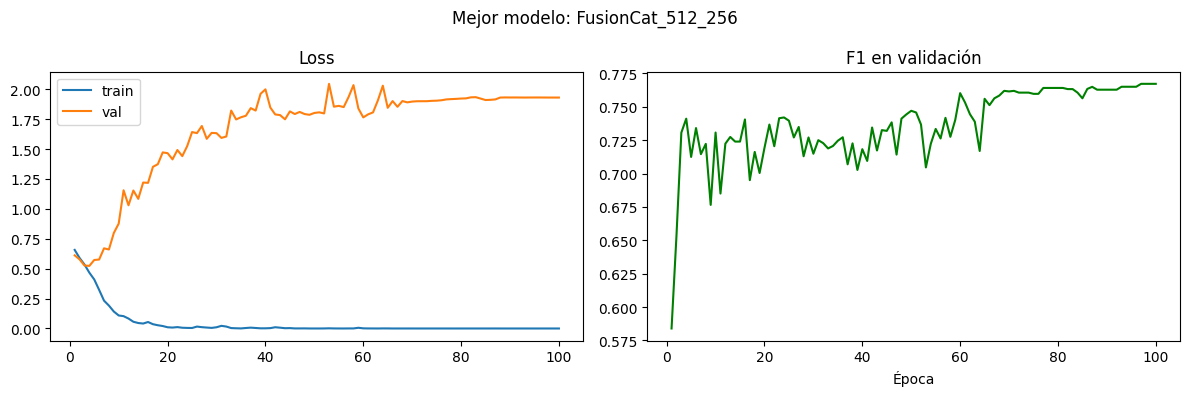

Curva guardada.


In [16]:
import matplotlib.pyplot as plt

hist = best['history']
epochs      = [h['epoch']     for h in hist]
train_loss  = [h['train_loss']for h in hist]
val_loss    = [h['val_loss']  for h in hist]
val_f1      = [h['f1']        for h in hist]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, train_loss, label='train')
axes[0].plot(epochs, val_loss,   label='val')
axes[0].set_title('Loss'); axes[0].legend()

axes[1].plot(epochs, val_f1, color='green')
axes[1].set_title('F1 en validación')
axes[1].set_xlabel('Época')

plt.suptitle(f"Mejor modelo: {best['name']}", fontsize=12)
plt.tight_layout()
plt.show()
print("Curva guardada.")